# Imports

In [1]:
CODE_DIR = "/home/cbarkhof/fall-2021"
import sys
sys.path.append(CODE_DIR)

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import numpyro

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

import os
import torch
import pandas as pd

from transformers import RobertaTokenizerFast
import torch.distributions as td

from clean_analysis.dp_mixture_for_surprisals import *
from clean_analysis.utils.PTB_preprocessing_steps import make_run_overview_df
from clean_analysis.utils.analysis_utils import get_n_data_samples_x_y
from clean_analysis.generative_analysis_models.generative_sequence_length_model_ptb import *



Running on NumPryo v0.8.0


# Globals

In [4]:
# CODE_DIR = "/home/cbarkhof/fall-2021"
# import sys
# sys.path.append(CODE_DIR)

# ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
# CHECKPOINT_DIR = f"{CODE_DIR}/run_files/checkpoints"

# SAMPLE_FILE = f"generative-samples.pt"
# CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

# SURPRISAL_SAMPLE_FILE = "surprisal_sample.pt"
# SURPRISAL_DATA_FILE = "surprisal_data.pt"
# SURPRISAL_COND_SAMPLE_FILE = "surprisal_conditional_sample.pt"

# TEST_VALID_EVAL_FILE = "test-valid-results.pt"

# BASE_ALPHA = 0.001
# MMD_REDO_FILE = f"mmd_redo-base-alpha-{BASE_ALPHA}.pt"

# Load lengths data and model groups

`ptb_lengths` has key-value structure:
- `data_group`:
    - `train `
    - `valid`
- `modelgroups`:
    - `<run_name>`

In [10]:
length_dict = torch.load("length_analysis_data.pt")
ptb_lengths = length_dict["ptb"]

# Get overview relevant runs

In [24]:
prefixes = ["(29-nov ptb-beta-vae)"]
overview_df = make_run_overview_df(prefixes, add_data_group=False)
overview_df.head()

,objective,dataset,l_rate,dropout,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
ptb BETA-VAE beta 1.5 dec: Strong roBERTa,BETA-VAE,ptb,0,0.000000,1.500000,0,0,0,strong_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.5] | STRONG | ...
ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa,BETA-VAE,ptb,0,0.000000,1.500000,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.5] | WEAK | Nz...
ptb BETA-VAE beta 1 dec: Strong roBERTa,BETA-VAE,ptb,0,0.000000,1,0,0,0,strong_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.0] | STRONG | ...
ptb BETA-VAE beta 1 dec: Weak-M roBERTa,BETA-VAE,ptb,0,0.000000,1,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.0] | WEAK | Nz...
ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa,BETA-VAE,ptb,0,0.000000,0.500000,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=0.5] | WEAK | Nz...


# Plot: data group - conditional model samples - unconditional model samples

In [11]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# ncols = 3

# dataset_name = "PTB"
# dictionary = ptb_lengths
# train_data = dictionary["data_group"]["train"]
# valid_data = dictionary["data_group"]["valid"]

# nrows = len(dictionary["model_groups"])

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(ncols*4, nrows*2))

# hist_kwargs = dict(density=True, bins=62, lw=0)

# for i in range(nrows):
#     axs[i, 0].hist(train_data, label="train", color="blue", alpha=0.4, **hist_kwargs)
#     axs[i, 0].hist(valid_data, label="valid", color="orange", alpha=0.4,  **hist_kwargs)
#     axs[i, 0].axvline(np.mean(train_data), color='blue')
#     axs[i, 0].axvline(np.mean(valid_data), color='orange')
#     title = f"Data group ({dataset_name.upper()})"
#     title += "\n" + f"min len: {min(train_data + valid_data)} max len: {max(train_data + valid_data)}"
#     axs[i, 0].set_title(title, size=8, y=1.02)

# for i, (model_name, con_uncon_dict) in enumerate(dictionary["model_groups"].items()):
#     for j, (k, lengths) in enumerate(con_uncon_dict.items()):
#         axs[i, j+1].hist(lengths, **hist_kwargs)
#         axs[i, j+1].axvline(np.mean(lengths), color='r')
#         min_len = min(lengths)
#         max_len = max(lengths)
#         #print(min_len, max_len)
#         title = model_name + "\n" + f"min len: {min_len} max len: {max_len}"
#         axs[i, j+1].set_title(title, size=8, y=1.02)

# y = 1.0

# plt.suptitle(f"{dataset_name}\nSequence lengths. Data group - Conditional generation - Unconditional generation", y=y)
# plt.tight_layout()
# plt.show()

In [12]:
# fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(4*3, 4*3))

# c = 0

# dataset_dict = ptb_lengths
# validation_data = dataset_dict["data_group"]["valid"]

# for model_group, con_uncon_dict in dataset_dict["model_groups"].items():
#     row = c // 3
#     col = c % 3

#     model_conditional_validation = con_uncon_dict["valid_conditional"]


#     axs[row, col].scatter(validation_data, model_conditional_validation, alpha=0.1, color="blue")
#     axs[row, col].set_xlabel("data lenght")
#     axs[row, col].set_ylabel("sampled length")
#     axs[row, col].set_title(model_group, size=8)
#     axs[row, col].set_xlim([0, 60])
#     axs[row, col].set_ylim([0, 60])

#     c += 1
        
# plt.tight_layout()

In [17]:
# Concat the validation and the train data (both N = 2000)
ptb_data = length_dict["ptb"]["data_group"]["valid"] + length_dict["ptb"]["data_group"]["train"]
type(ptb_data), len(ptb_data)

(list, 4000)

In [18]:
NUM_CHAINS = 1
NUM_WARMUP = 1000
NUM_SAMPLES = 2000

print("Num train + valid samples", len(ptb_data))

model = GenSeqLenModelPTB(
    ["ptb_train_data"],
    [ptb_data],
    gamma_shape=[10., 1.9], 
    num_comps=5,
    DP_alpha=0.1, 
    num_chains=NUM_CHAINS, 
    num_warmup=NUM_WARMUP, 
    num_samples=NUM_SAMPLES)

Num train + valid samples 4000


# Prior predictive checks

rv      shape
------  -----------
beta    (100, 4)
lambda  (100, 5)
omega   (100, 5)
rate    (100, 5)
y       (100, 2000)
z       (100, 2000)


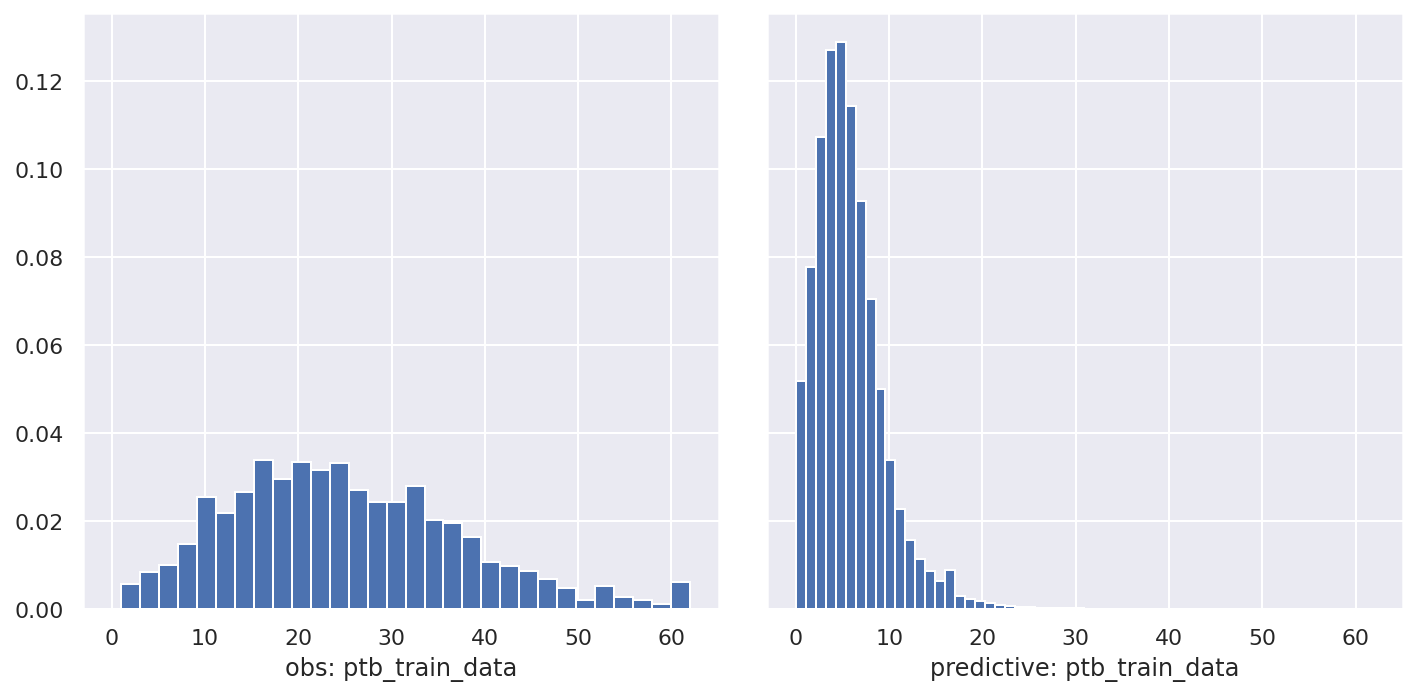

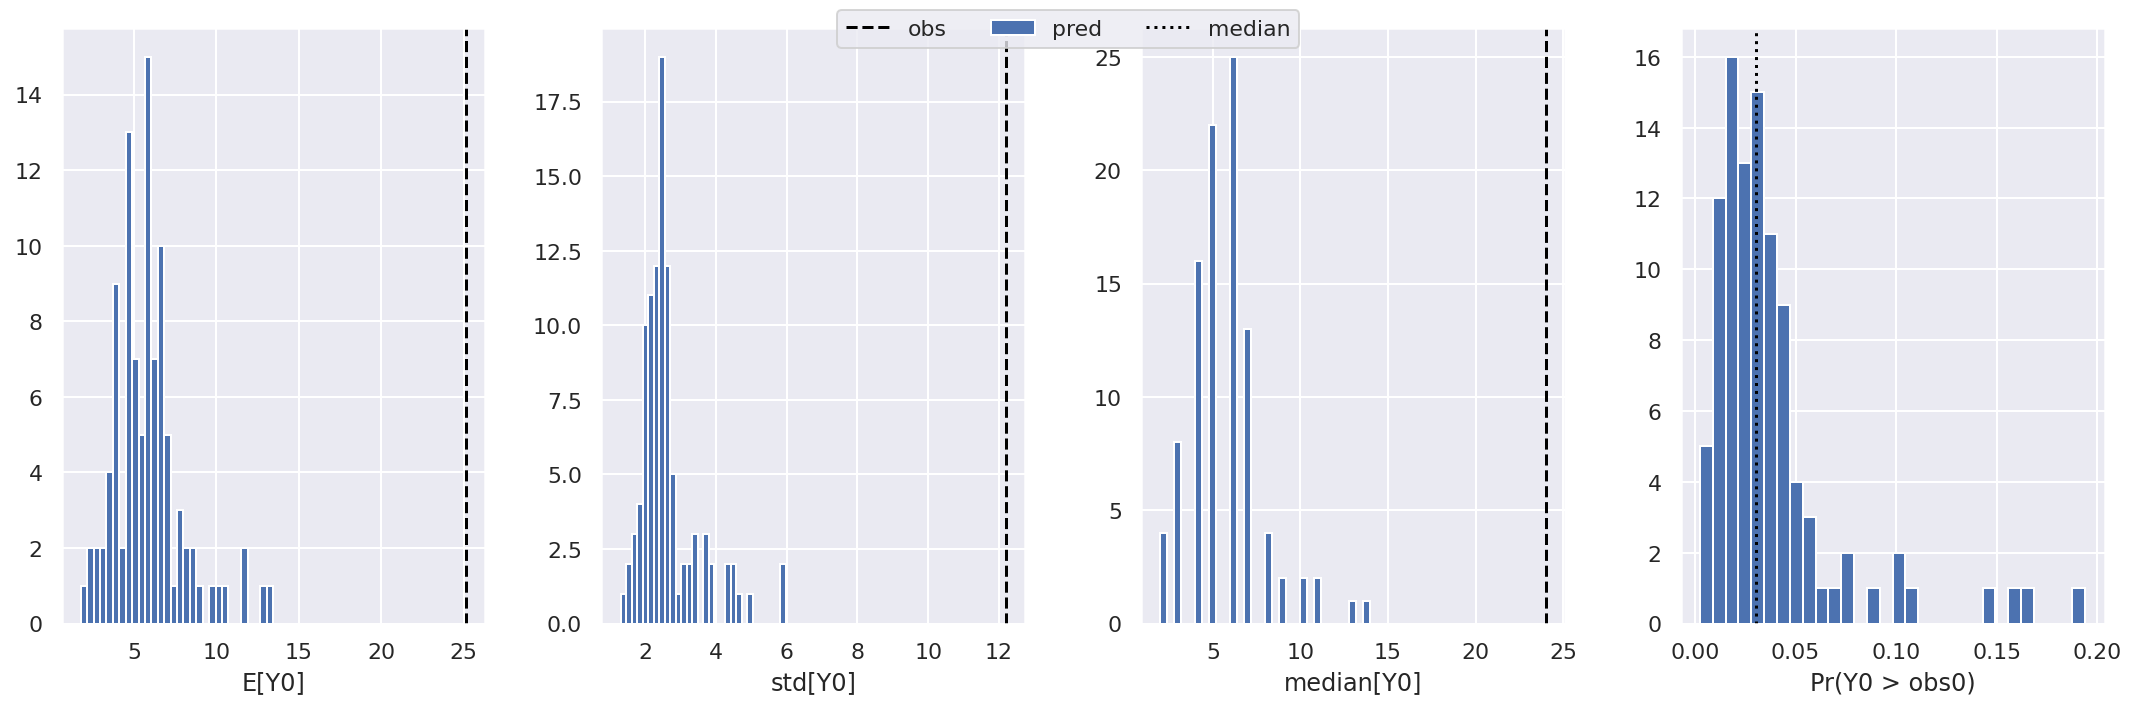

In [14]:
prior_samples = model.draw_prior_predictions()
print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
_ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30])
_ = plot_checks(model, prior_samples['y'])

# Run sampler

In [19]:
model.run()

sample: 100%|██████████| 3000/3000 [00:26<00:00, 114.24it/s, 15 steps of size 2.05e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.04      0.01      0.04      0.03      0.06    959.67      1.00
   beta[1]      0.22      0.02      0.22      0.18      0.25    874.84      1.00
   beta[2]      0.47      0.02      0.47      0.44      0.51   1218.40      1.00
   beta[3]      0.81      0.02      0.81      0.78      0.84   1495.69      1.00
 lambda[0]      5.47      0.47      5.44      4.67      6.24    890.57      1.00
 lambda[1]      7.14      0.42      7.15      6.36      7.77   1019.61      1.00
 lambda[2]      9.07      0.39      9.07      8.42      9.70   1134.68      1.00
 lambda[3]     11.61      0.43     11.63     10.90     12.29    951.32      1.00
 lambda[4]     15.85      0.64     15.86     14.87     16.93   1818.16      1.00

Number of divergences: 0
posterior samples shapes:
beta (2000, 4)
lambda (2000, 5)
omega (2000, 5)
rate (2000, 5)


# Posterior predictive checks

rv     shape
-----  ------------
omega  (2000, 5)
rate   (2000, 5)
y      (2000, 4000)
z      (2000, 4000)


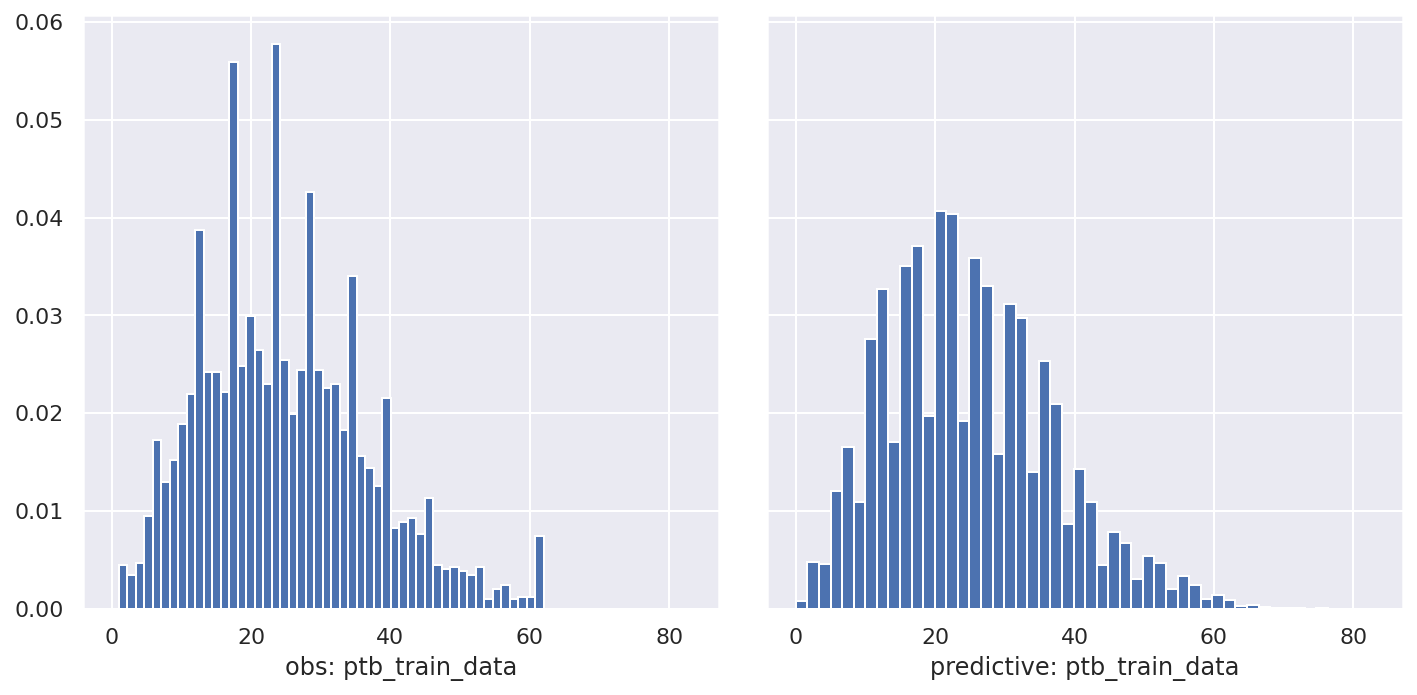

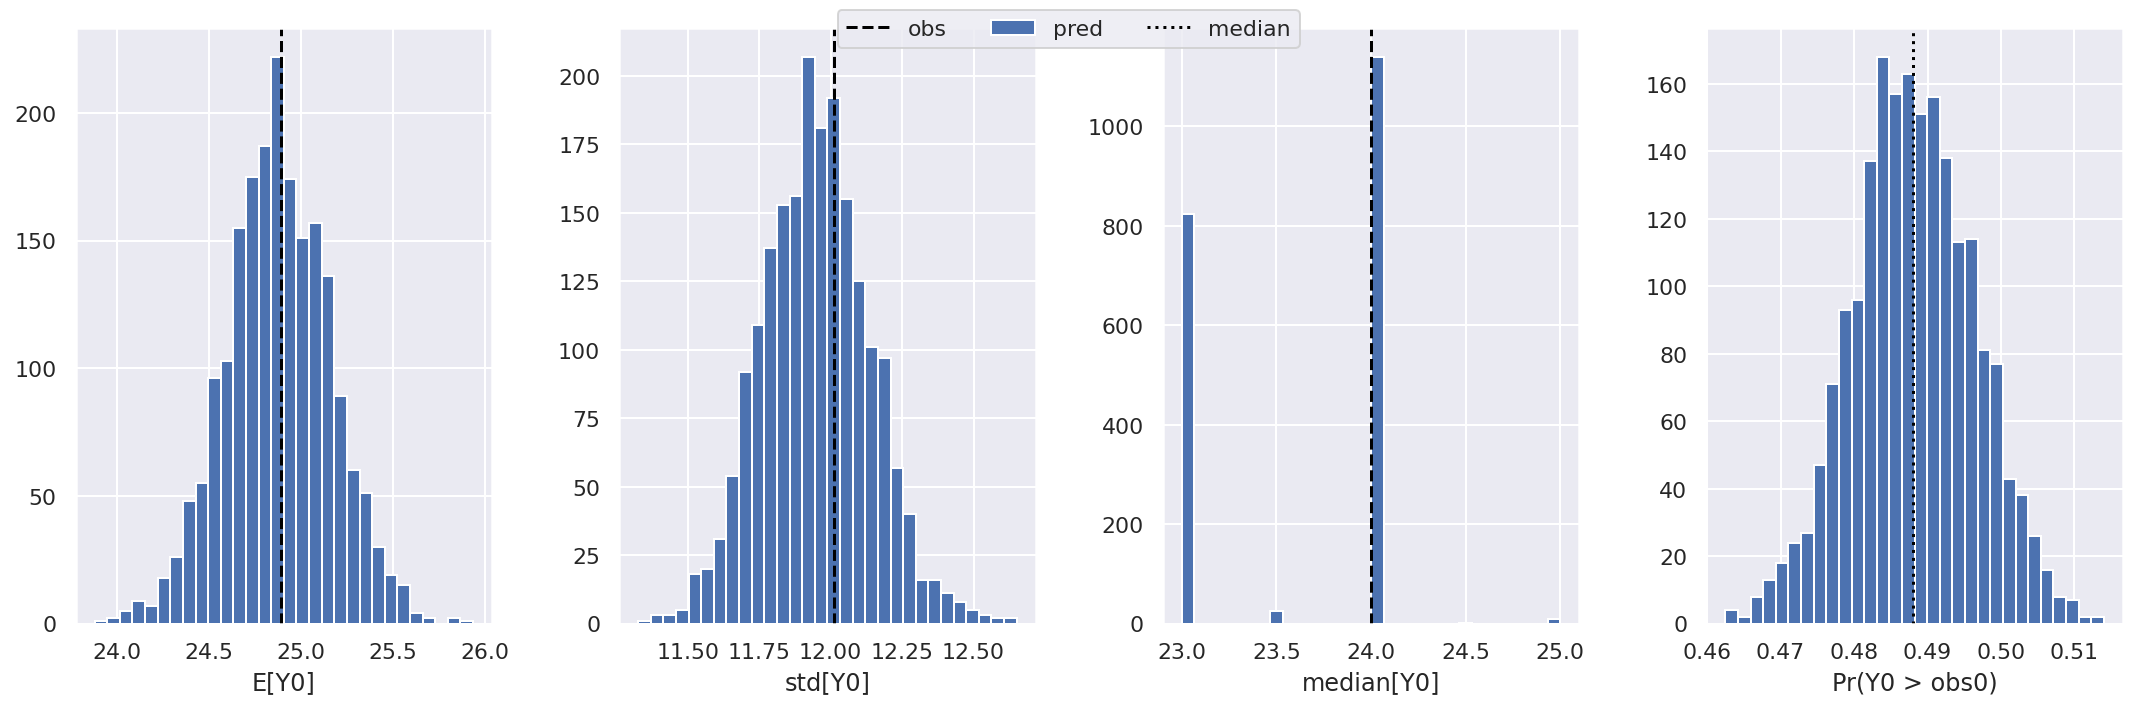

In [20]:
posterior_samples = model.draw_posterior_predictions()
print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))
_ = plot_predictions(model, posterior_samples['y'], bins=[50, 50], sharex='row', sharey='row')
_ = plot_checks(model, posterior_samples['y'])


# Compute surprisal values

In [27]:
surprisal_values = dict()

local_samples = model.infer_local_assignments(model.posterior_samples, model.y)
print(tabulate([(k, v.shape) for k, v in local_samples.items()], headers=['rv', 'shape']))

for i, (model_name, con_uncon_dict) in enumerate(ptb_lengths["model_groups"].items()):
    print(i, model_name)

    conditional_lengths = con_uncon_dict["valid_conditional"]
    unconditional_length = con_uncon_dict["unconditional"]

    # Estimate log_p_x_y
    cond_cond = - model.estimate_log_p_x_conditional(conditional_lengths, local_samples=local_samples)

    # Estimate log_p_x (returns a numpy array)
    uncond_uncond = - model.estimate_log_p_x(unconditional_length, posterior_samples=posterior_samples)

    # Estimate log_p_x (returns a numpy array)
    uncond_cond = - model.estimate_log_p_x(conditional_lengths, posterior_samples=posterior_samples)

    surprisal_values[model_name] = dict(
        conditional_conditional=cond_cond, 
        unconditional_unconditional=uncond_uncond,
        unconditional_conditional=uncond_cond
    )

surprisal_values["data_group"] = {
    "unconditional_unconditional": - model.estimate_log_p_x(ptb_lengths["data_group"]["valid"], posterior_samples=posterior_samples),
    "conditional_conditional": - model.estimate_log_p_x_conditional(ptb_lengths["data_group"]["valid"], local_samples=local_samples)
}
surprisal_values["data_group"]["unconditional_conditional"] = surprisal_values["data_group"]["unconditional_unconditional"]

torch.save(surprisal_values, "PTB_seq_len_surprisal_values.pt")

# surprisal_values = torch.load("PTB_seq_len_surprisal_values.pt")


rv      shape
------  ------------
z       (2000, 4000)
rate_z  (2000, 4000)
0 ptb BETA-VAE beta 1.5 dec: Strong roBERTa
1 ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa
2 ptb BETA-VAE beta 1 dec: Strong roBERTa
3 ptb BETA-VAE beta 1 dec: Weak-M roBERTa
4 ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa
5 ptb BETA-VAE beta 0.5 dec: Strong roBERTa
6 ptb BETA-VAE beta 0.1 dec: Strong roBERTa
7 ptb BETA-VAE beta 0 dec: Strong roBERTa
8 ptb BETA-VAE beta 0 dec: Weak-M roBERTa
9 ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa


xx dict_keys(['ptb BETA-VAE beta 1.5 dec: Strong roBERTa', 'ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa', 'ptb BETA-VAE beta 1 dec: Strong roBERTa', 'ptb BETA-VAE beta 1 dec: Weak-M roBERTa', 'ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa', 'ptb BETA-VAE beta 0.5 dec: Strong roBERTa', 'ptb BETA-VAE beta 0.1 dec: Strong roBERTa', 'ptb BETA-VAE beta 0 dec: Strong roBERTa', 'ptb BETA-VAE beta 0 dec: Weak-M roBERTa', 'ptb BETA-VAE beta 0.1 dec: Weak-M roBERTa', 'data_group'])


I0104 07:49:54.782219 23364227067648 utils.py:145] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0104 07:49:54.784327 23364227067648 utils.py:157] NumExpr defaulting to 8 threads.


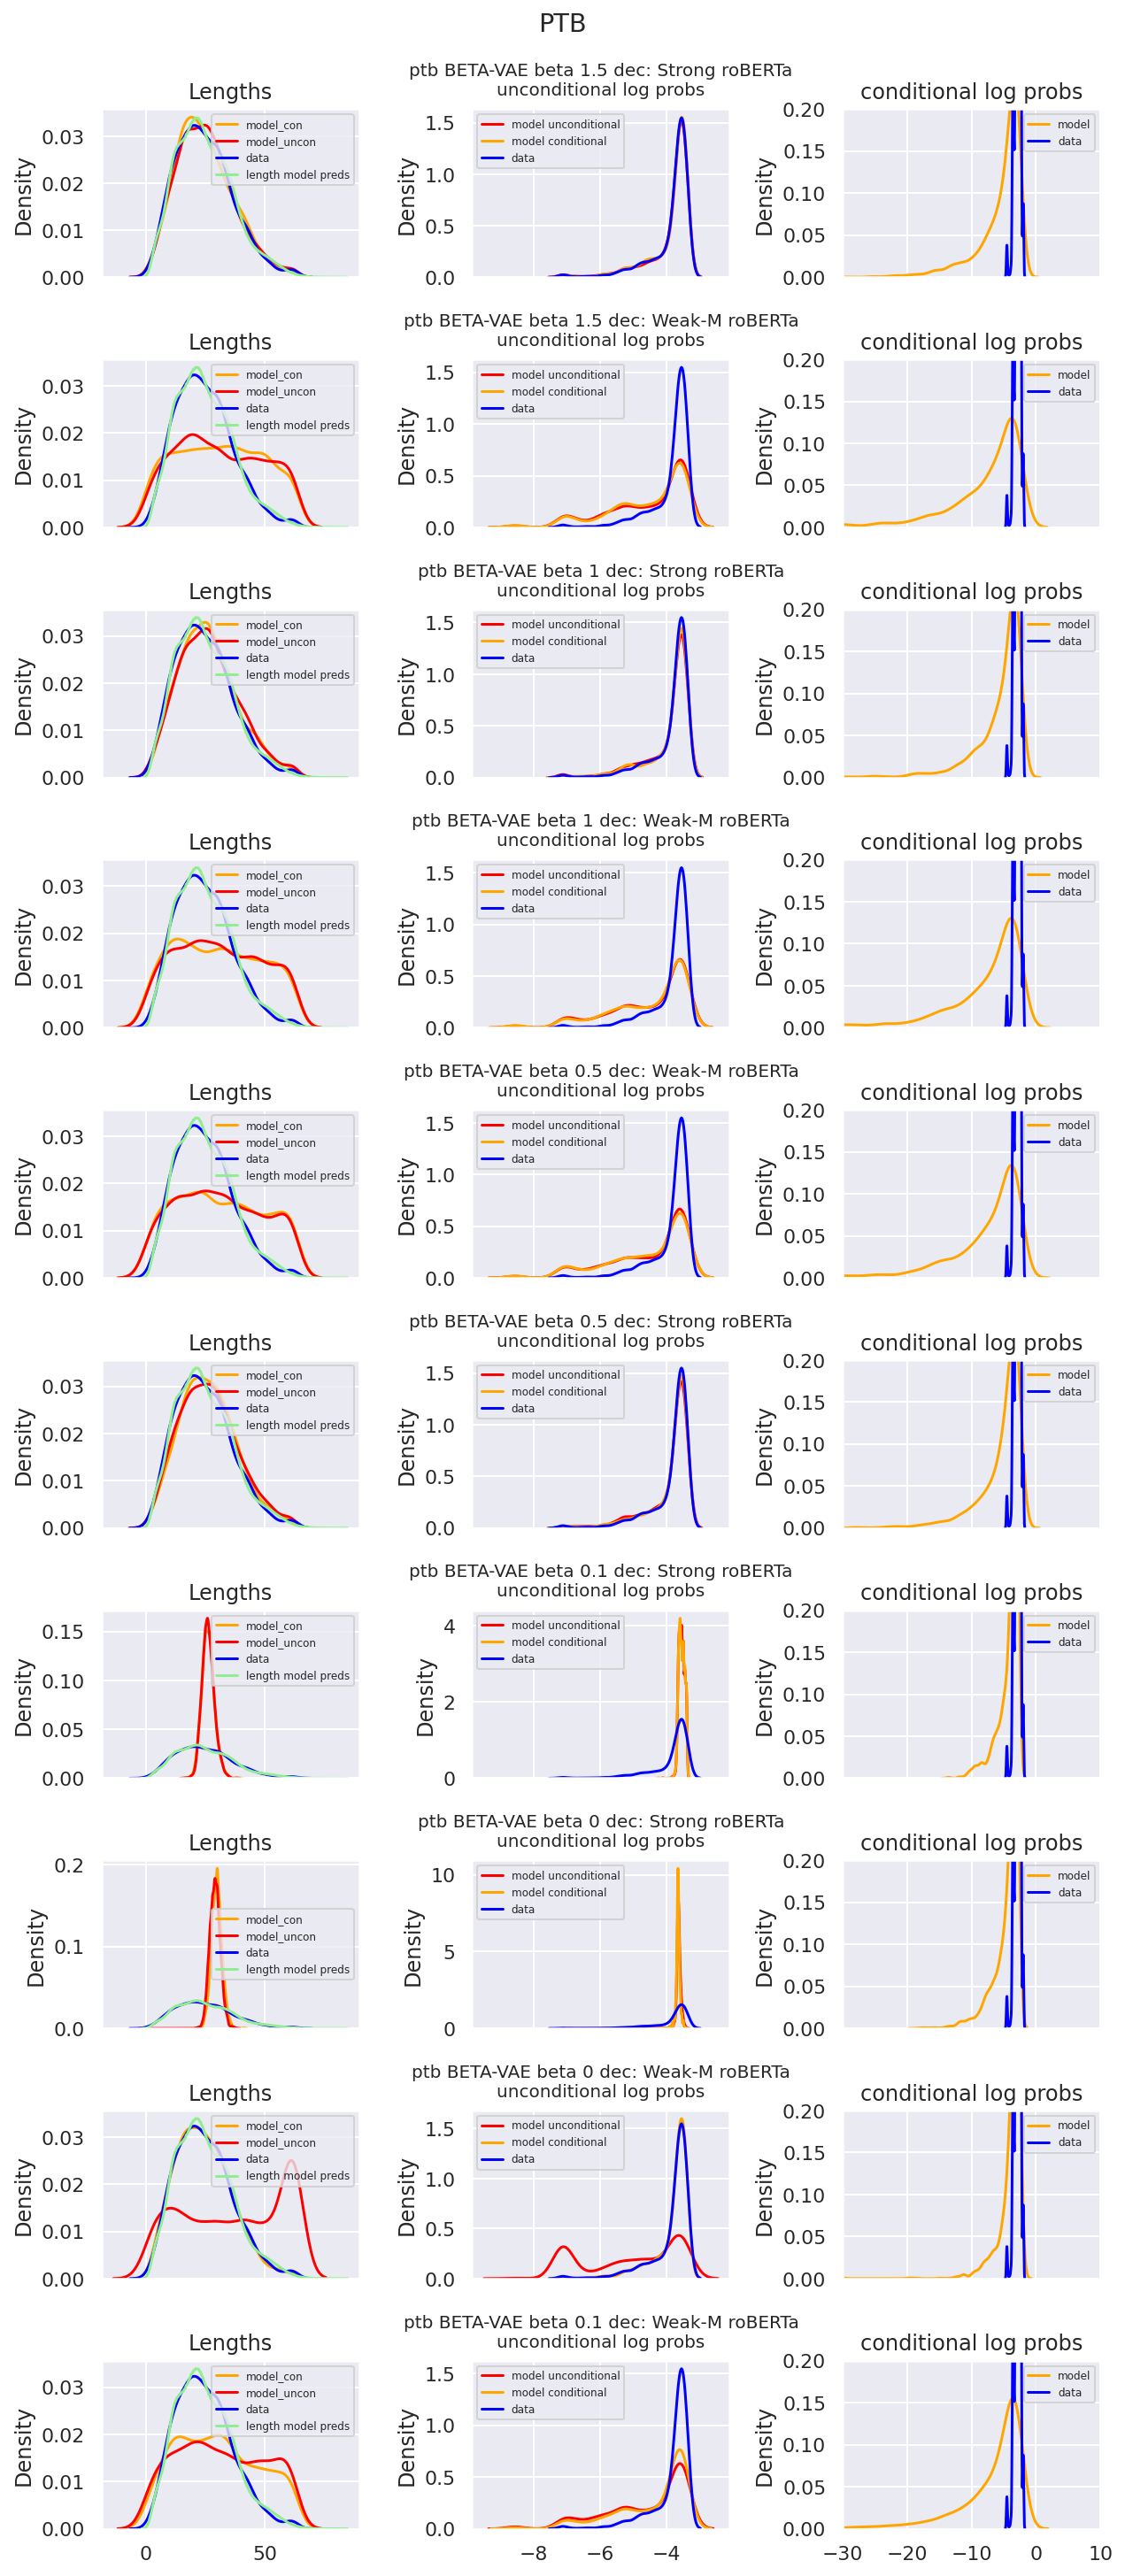

In [51]:
log_probs_ptb = dict()
for k, v in surprisal_values.items():
    log_probs_ptb[k] = dict()
    for k1, v1 in v.items():
        log_probs_ptb[k][k1] = -v1

ptb_conditional = log_probs_ptb["data_group"]["conditional_conditional"]
ptb_unconditional = log_probs_ptb["data_group"]["unconditional_unconditional"]

c_dict = {
    "data": "blue",
    "model_uncon": "red",
    "model_con": "orange",
    "preds": "lightgreen"
}

dataset = "ptb"    
N = len(surprisal_values) - 1 # minus data group

nrows = N
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2*nrows), sharex="col")
fig.set_facecolor("white")

row = 0
for model_name in log_probs_ptb.keys():

    if model_name != "data_group":

        preds = posterior_samples["y"][:, :2000]
             
        # LENGTH PLOTS
        sns.kdeplot(x=ptb_lengths["model_groups"][model_name]["valid_conditional"], 
                    ax=axs[row, 0], label="model_con", color=c_dict["model_con"])

        sns.kdeplot(x=ptb_lengths["model_groups"][model_name]["unconditional"], 
                    ax=axs[row, 0], label="model_uncon", color=c_dict["model_uncon"])

        sns.kdeplot(x=ptb_lengths["data_group"]["valid"], 
                    ax=axs[row, 0], label="data", color=c_dict["data"])

        sns.kdeplot(x=preds.flatten(), 
                    ax=axs[row, 0], label="length model preds", color=c_dict["preds"])

        axs[row, 0].set_title("Lengths")
        axs[row, 0].legend(prop={"size":6})

        # CONDITIONAL & UNCONDITIONAL LOG PROBS
        # plot unconditional stistic for unconditional model samples
        sns.kdeplot(x=log_probs_ptb[model_name]["unconditional_unconditional"], 
                    ax=axs[row, 1], label="model unconditional", color=c_dict["model_uncon"])

        # plot unconditional statistic for conditional model samples
        sns.kdeplot(x=log_probs_ptb[model_name]["unconditional_conditional"], 
                    ax=axs[row, 1], label="model conditional", color=c_dict["model_con"])

        axs[row, 1].set_title(model_name + "\nunconditional log probs", y=1.02, size=10)

        # plot conditional statistic for conditional model samples
        sns.kdeplot(x=log_probs_ptb[model_name]["conditional_conditional"], 
                    ax=axs[row, 2], label="model", color=c_dict["model_con"])
        axs[row, 2].set_title("conditional log probs")

        sns.kdeplot(x=ptb_conditional, 
                        ax=axs[row, 2], label="data", color=c_dict["data"])
        sns.kdeplot(x=ptb_unconditional, 
                    ax=axs[row, 1], label="data", color=c_dict["data"])


        axs[row, 1].legend(prop={"size":6})
        axs[row, 2].legend(prop={"size":6})

        axs[row, 2].set_ylim([0, 0.2])
        axs[row, 2].set_xlim([-30, 10])

        row += 1

plt.tight_layout()
plt.suptitle(dataset.upper(), y=1.01)
plt.show()



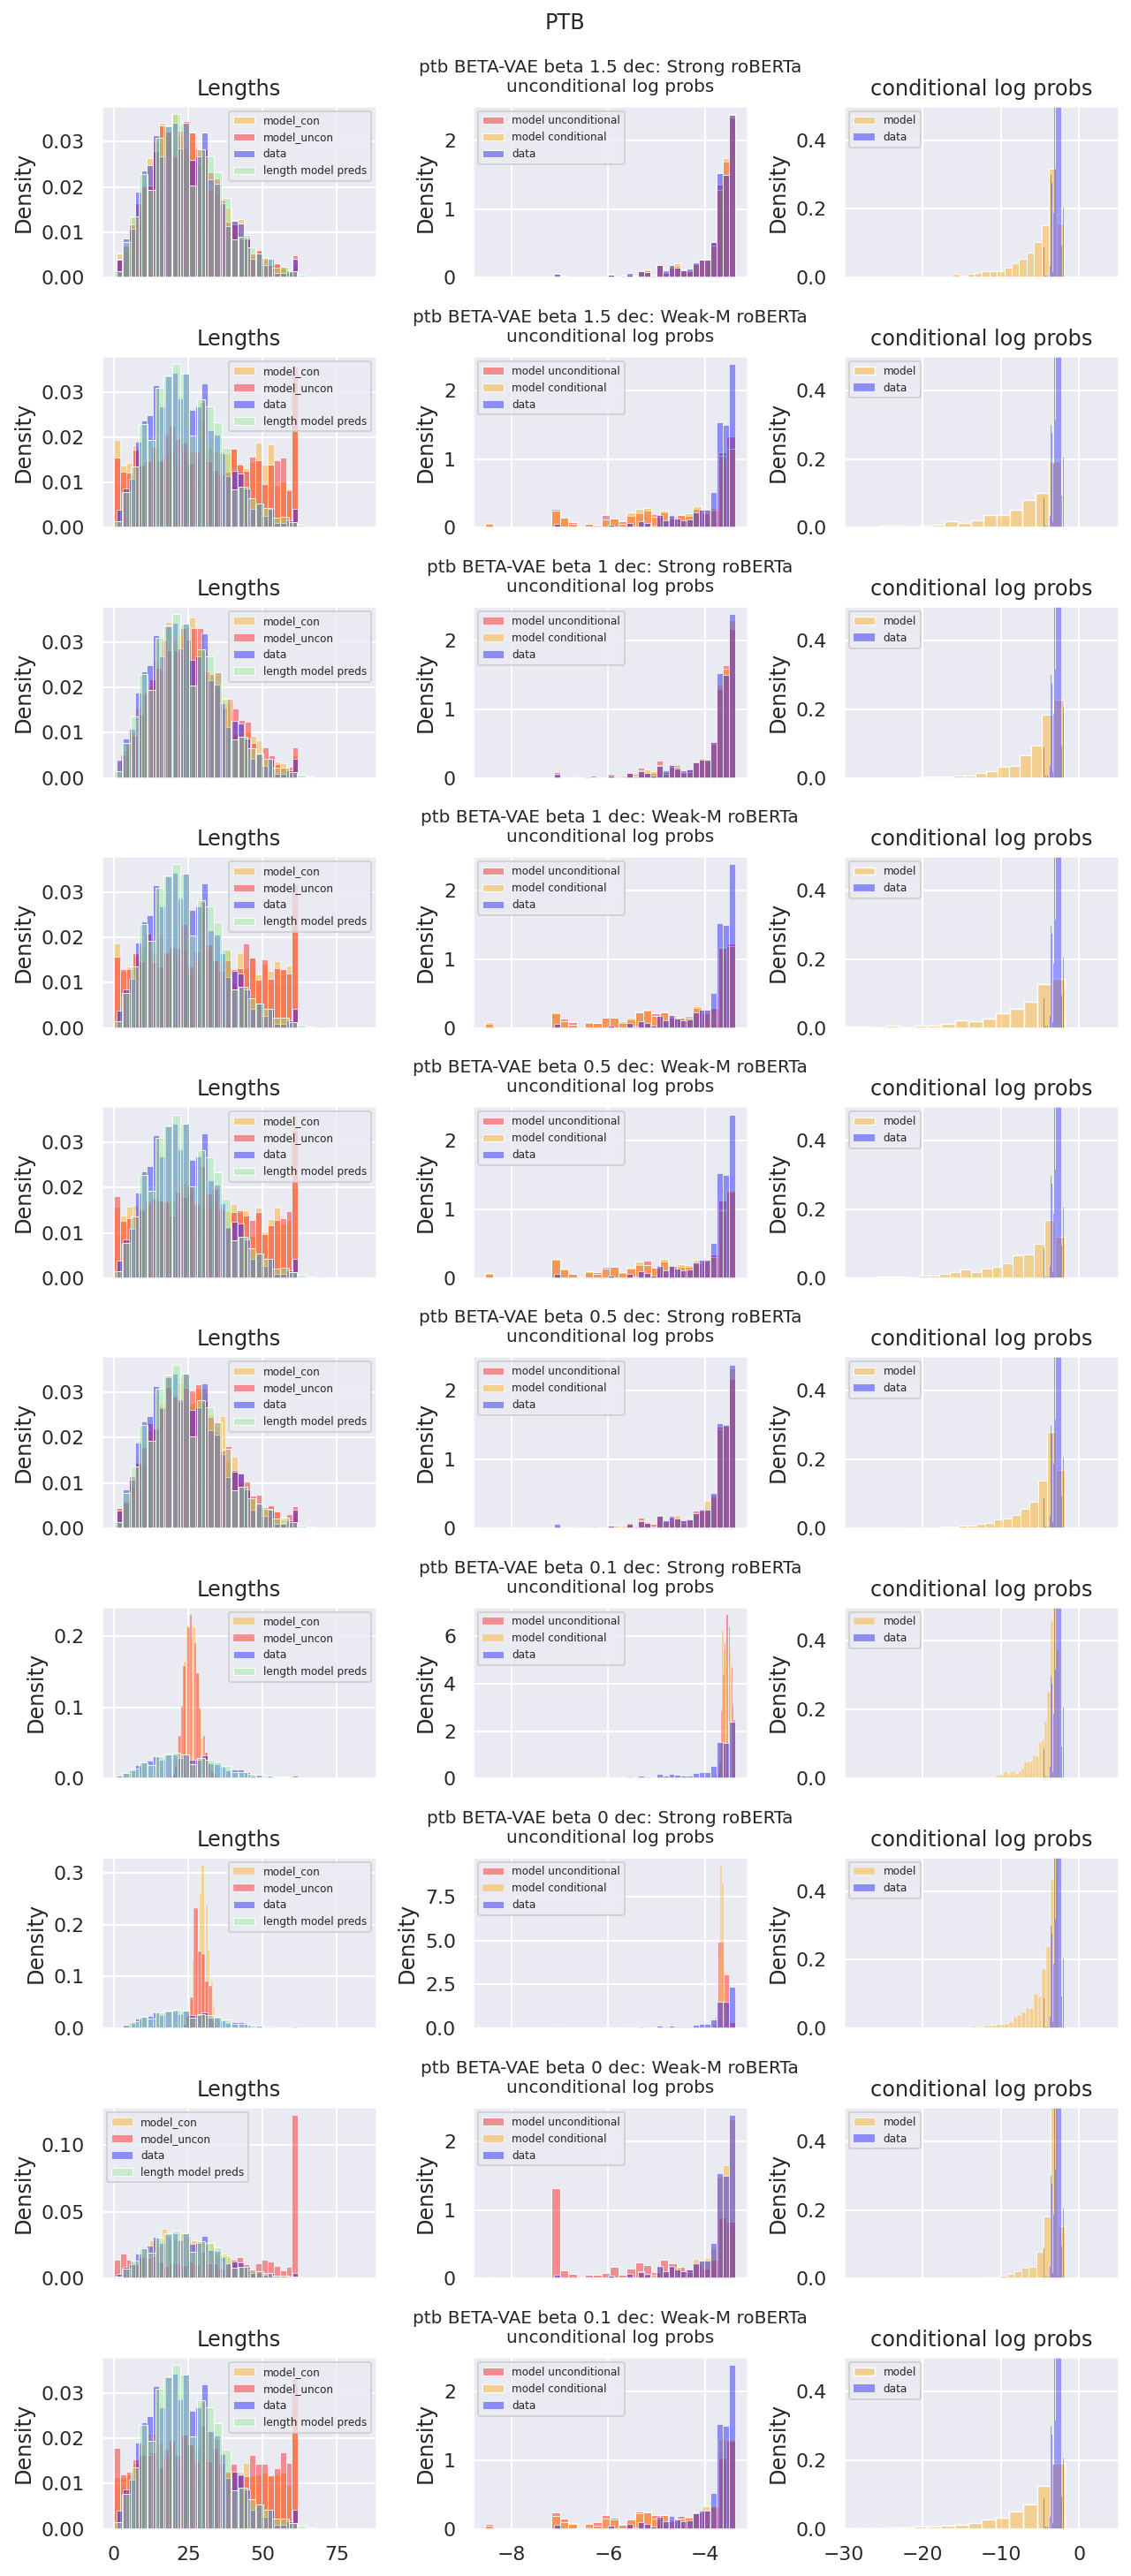

In [48]:
ptb_conditional = log_probs_ptb["data_group"]["conditional_conditional"]
ptb_unconditional = log_probs_ptb["data_group"]["unconditional_unconditional"]

# yahoo_answer_conditional = log_probs["yahoo_answer"]["data_group"]["conditional_conditional"]
# yahoo_answer_unconditional = log_probs["yahoo_answer"]["data_group"]["unconditional_unconditional"]


c_dict = {
    "data": "blue",
    "model_uncon": "red",
    "model_con": "orange",
    "preds": "lightgreen"
}

dataset = "ptb"    
N = len(log_probs_ptb) - 1 # minus data group

nrows = N
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2*nrows), sharex="col")
fig.set_facecolor("white")

row = 0
for model_name in log_probs_ptb:

    if model_name != "data_group":

        preds = posterior_samples["y"][:, :2000]

        # LENGTH PLOTS
        sns.histplot(x=ptb_lengths["model_groups"][model_name]["valid_conditional"], 
                    ax=axs[row, 0], label="model_con", color=c_dict["model_con"], alpha=0.4, bins=30, stat="density", )

        sns.histplot(x=ptb_lengths["model_groups"][model_name]["unconditional"], 
                    ax=axs[row, 0], label="model_uncon", color=c_dict["model_uncon"], alpha=0.4, bins=30, stat="density", )

        sns.histplot(x=ptb_lengths["data_group"]["valid"], 
                    ax=axs[row, 0], label="data", color=c_dict["data"], alpha=0.4, bins=30, stat="density", )

        sns.histplot(x=preds.flatten(), 
                    ax=axs[row, 0], label="length model preds", color=c_dict["preds"], alpha=0.4,bins=30,  stat="density")

        axs[row, 0].set_title("Lengths")
        axs[row, 0].legend(prop={"size":6})

        # CONDITIONAL & UNCONDITIONAL LOG PROBS
        # plot unconditional stistic for unconditional model samples
        sns.histplot(x=log_probs_ptb[model_name]["unconditional_unconditional"], 
                    ax=axs[row, 1], label="model unconditional", color=c_dict["model_uncon"],stat="density",bins=30,   alpha=0.4)

        # plot unconditional statistic for conditional model samples
        sns.histplot(x=log_probs_ptb[model_name]["unconditional_conditional"], 
                    ax=axs[row, 1], label="model conditional", color=c_dict["model_con"], stat="density",bins=30,  alpha=0.4)

        axs[row, 1].set_title(model_name + "\nunconditional log probs", y=1.02, size=10)

        # plot conditional statistic for conditional model samples
        sns.histplot(x=log_probs_ptb[model_name]["conditional_conditional"], 
                    ax=axs[row, 2], label="model", color=c_dict["model_con"], stat="density",bins=30,  alpha=0.4)
        axs[row, 2].set_title("conditional log probs")

        sns.histplot(x=ptb_conditional, 
                        ax=axs[row, 2], label="data", color=c_dict["data"], stat="density",bins=30,  alpha=0.4)
        sns.histplot(x=ptb_unconditional, 
                    ax=axs[row, 1], label="data", color=c_dict["data"], stat="density",bins=30,  alpha=0.4)


        axs[row, 1].legend(prop={"size":6})
        axs[row, 2].legend(prop={"size":6})

        axs[row, 2].set_ylim([0, 0.5])
        axs[row, 2].set_xlim([-30, 5])

        row += 1

plt.tight_layout()
plt.suptitle(dataset.upper(), y=1.01)
plt.show()



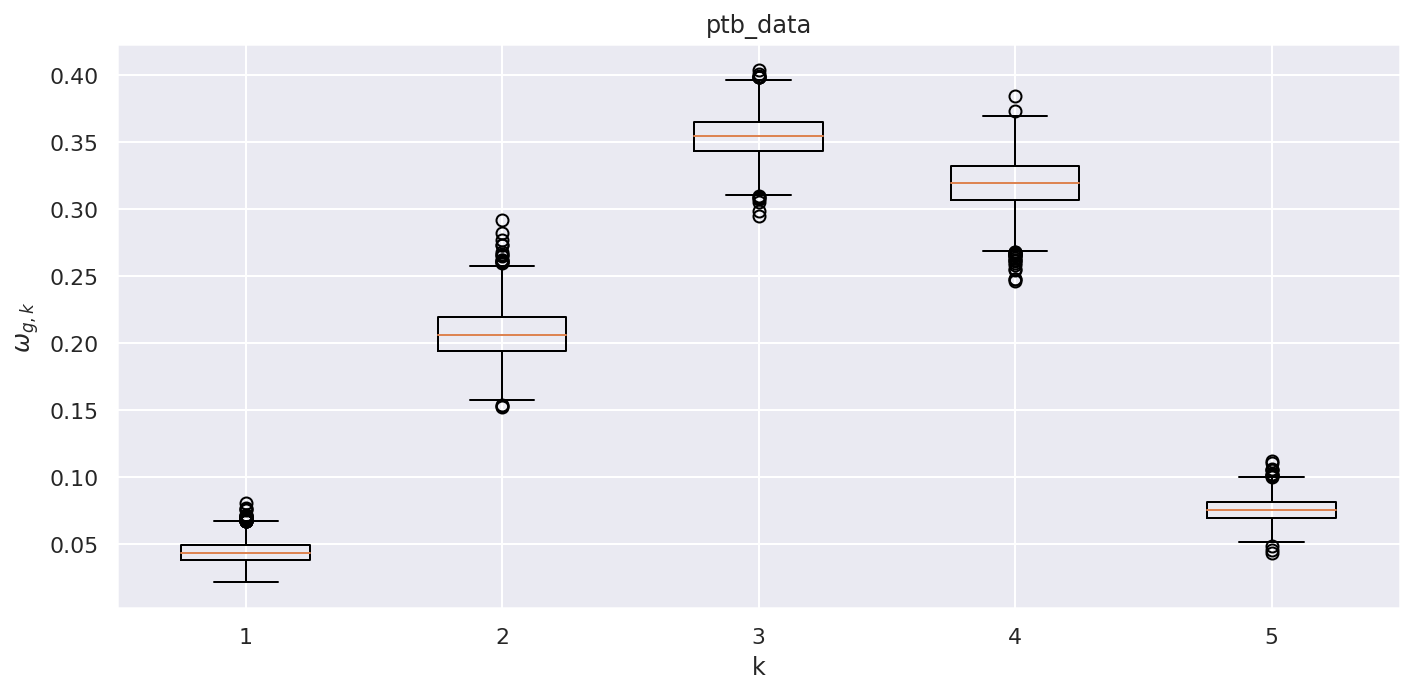

In [28]:
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 5))
_ = ax.boxplot(posterior_samples['omega'][:,:].transpose())
_ = ax.set_title(model.group_names[0])
_ = ax.set_xlabel('k')
_ = ax.set_ylabel(r'$\omega_{g,k}$')
fig.tight_layout(h_pad=2, w_pad=2)

In [30]:
# This code does not work for a single group

# kls = []
# for g in range(model.G):
#     p = posterior_samples['omega'][:,0,:]
#     q = posterior_samples['omega'][:,g,:]
#     kls.append((p * (np.log(p) - np.log(q))).sum(-1))

# _ = plt.boxplot(kls[1:])
# _ = plt.ylabel(r'$E[KL(\omega_0||\omega_g)]$')
# _ = plt.xticks(np.arange(model.G - 1) + 1, model.group_names[1:]) 

In [ ]:
# import scipy.stats as stats

# def plot_poisson_pmf(ax, rate, color, linestyle, num_points=100):
#     x = np.linspace(0, 4*rate, num_points)
#     return ax.plot(x, stats.norm.pdf(x, mu, sigma), color=color, linestyle=linestyle)

In [33]:
posterior_samples["omega"].shape

(2000, 5)

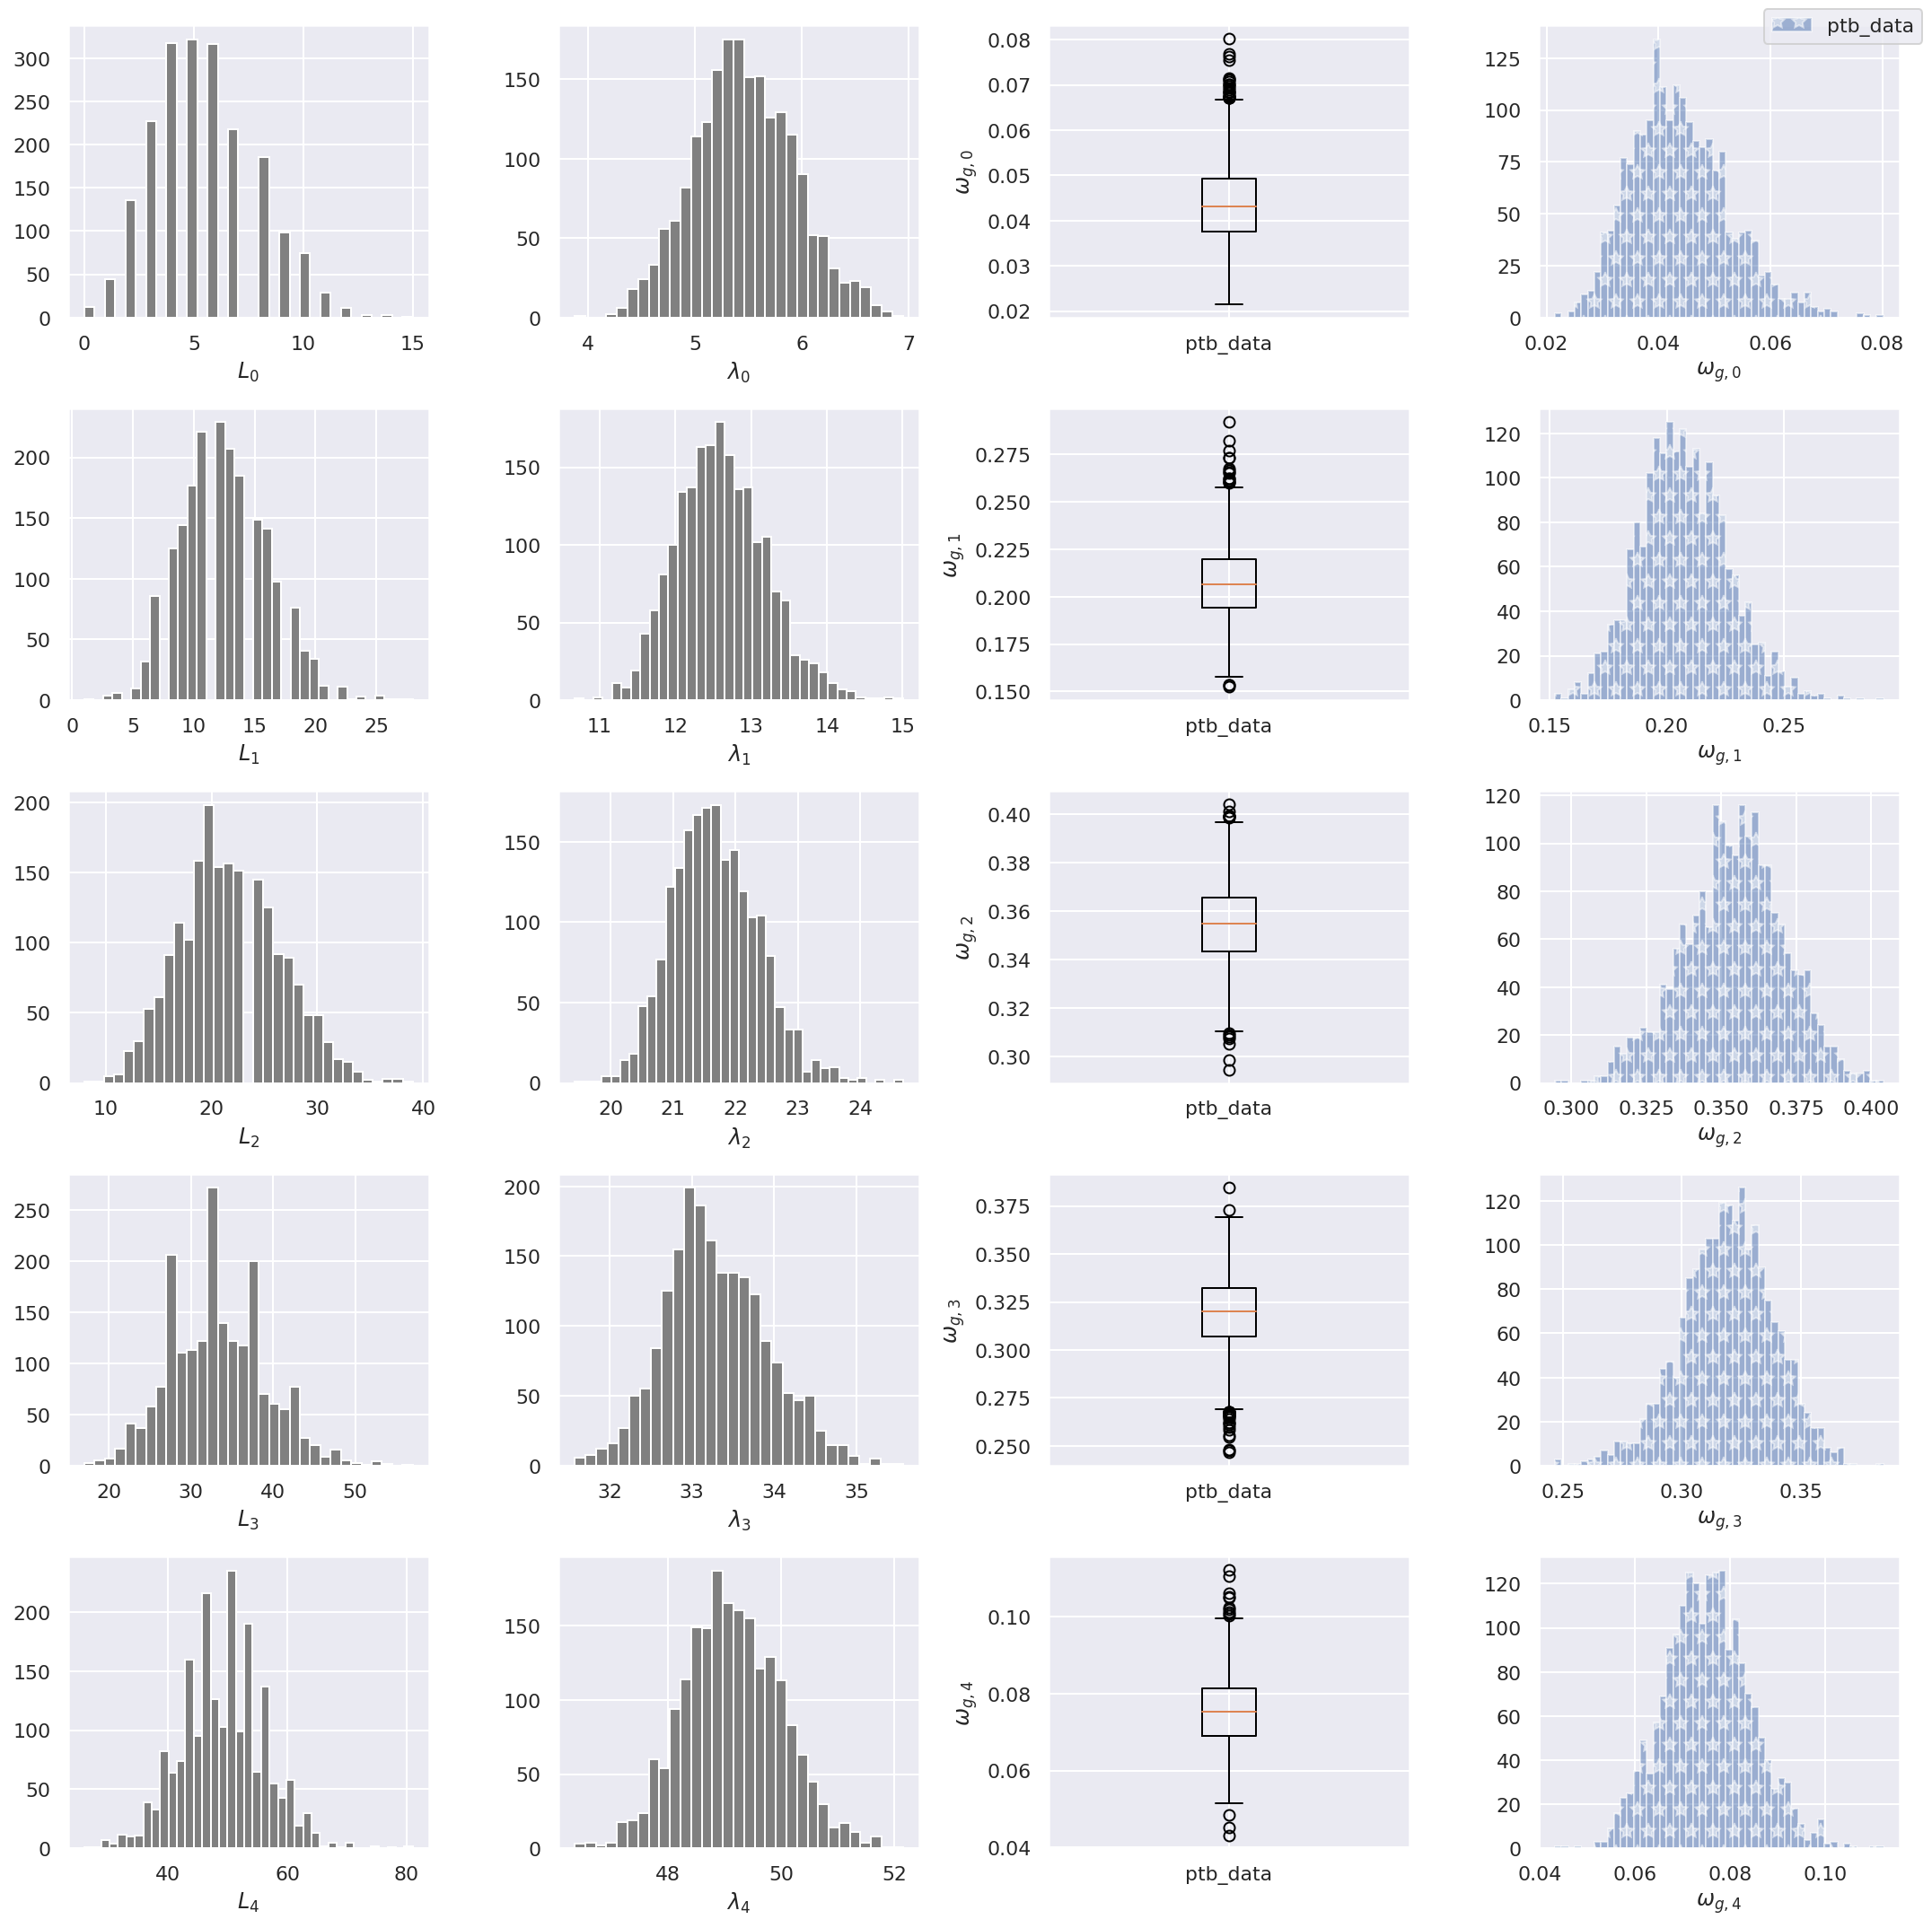

In [38]:
hatches = ['*', 'o', '/', '-']
fig, ax = plt.subplots(model.T, 4, figsize=(15, 15))
for t in range(model.T):
    _ = ax[t, 0].hist(np.random.poisson(posterior_samples['rate'][:, t]), color='gray', bins='auto')
    _ = ax[t, 0].set_xlabel(r'$L_{%d}$' % t)
    
    _ = ax[t, 1].hist(posterior_samples['rate'][:, t], color='gray', bins='auto')
    _ = ax[t, 1].set_xlabel(r'$\lambda_{%d}$' % t)
    
    _ = ax[t, 2].boxplot([posterior_samples['omega'][:,t].transpose() for g in range(model.G)])
    _ = ax[t, 2].set_xticklabels(model.group_names)
    _ = ax[t, 2].set_ylabel(r'$\omega_{g,%d}$' % t)    
    pal = cycle(sns.color_palette())
    
#     for g in range(model.G):
    _ = ax[t, 3].hist(posterior_samples['omega'][:,t], alpha=0.5, color=next(pal), hatch=hatches[0], bins=50, label=model.group_names[0] if t==0 else None)
    _ = ax[t, 3].set_xlabel(r'$\omega_{g,%d}$' % t)

fig.legend()    
fig.tight_layout(h_pad=1, w_pad=1)

In [96]:
def log_pdf(y, omega_g, rate):
    # w_g: [S, T]    
    # rate: [S, T]
    # x: [S, N] ->[N, S] -> [N, S, T]
    y = jnp.repeat(jnp.expand_dims(y, -1), omega_g.shape[-1], -1)
    # [1, S, T] + [N, S, T] -> [N, S] -> [N]
    return jnp.logaddexp(jnp.log(omega_g) + dist.Poisson(rate).log_prob(y), -1).mean(-1)

In [111]:
def kl_estimate(x, a, b, num_predictive_samples, num_posterior_samples, samples):
    S = samples['y'].shape[0]
    
    idx1 = np.random.choice(S, size=num_posterior_samples)
    #idx2 = np.random.choice(S, size=num_posterior_samples)
    rate1 = samples['rate'][idx1]
    rate2 = samples['rate'][idx1]
    
    idx1 = np.random.choice(S, size=num_posterior_samples)
    #idx2 = np.random.choice(S, size=num_posterior_samples)
    omega_a = samples['omega'][idx1, a]
    omega_b = samples['omega'][idx1, b]    

    # [K]
    idx_a = np.random.choice(len(x), p=(x==a)/(model.x==a).sum(-1), size=num_posterior_samples)
    idx1 = np.random.choice(S, size=num_posterior_samples)    
    y = samples['y'][idx1][np.arange(num_posterior_samples), idx_a]
    
    print((log_pdf(y, omega_a, rate1)-log_pdf(y, omega_b, rate2)).mean())
#     print(samples['y'][].shape)
    # sample y from a given group a    
#     log_pdf(y, omega_a, rate[idx1])
#     log_pdf(y, omega_b, rate[idx2])

In [112]:
kl_estimate(model.x, 0, 2, 30, 1000, posterior_samples)

-0.00013272924


In [3]:
global_stats_df = pd.read_csv("global_stats/ptb_global_stats.csv", index_col=0)
global_stats_df.head()

,test-elbo mean,test-distortion mean,test-kl_prior_post mean,test-mean_mean mean,test-std_across_x_mean mean,test-std_across_z_mean mean,test-mean_scale mean,test-std_across_x_scale mean,test-std_across_z_scale mean,valid-elbo mean,...,objective,dataset,l_rate,dropout,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
ptb BETA-VAE beta 1.5 dec: Strong roBERTa,-89.471437,89.467254,0.004183,-0.000129,0.002534,0.004731,0.997057,0.002761,0.002408,-90.551288,...,BETA-VAE,ptb,0,0.000000,1.500000,0,0,0,strong_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.5] | STRONG | ...
ptb BETA-VAE beta 1.5 dec: Weak-M roBERTa,-158.046392,156.063279,1.983112,-0.001304,0.066467,0.107206,0.990869,0.005376,0.067169,-158.675220,...,BETA-VAE,ptb,0,0.000000,1.500000,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.5] | WEAK | Nz...
ptb BETA-VAE beta 1 dec: Strong roBERTa,-89.222751,89.207397,0.015353,0.000780,0.008256,0.009873,0.993630,0.004453,0.003476,-90.600456,...,BETA-VAE,ptb,0,0.000000,1.000000,0,0,0,strong_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.0] | STRONG | ...
ptb BETA-VAE beta 1 dec: Weak-M roBERTa,-155.590748,151.869463,3.721285,0.000319,0.069453,0.140216,0.983780,0.008225,0.097588,-155.929820,...,BETA-VAE,ptb,0,0.000000,1.000000,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=1.0] | WEAK | Nz...
ptb BETA-VAE beta 0.5 dec: Weak-M roBERTa,-153.884875,145.036578,8.848297,-0.003714,0.065571,0.198196,0.967567,0.013167,0.155593,-153.620325,...,BETA-VAE,ptb,0,0.000000,0.500000,0,0,0,weak_memory_distil_roberta_decoder,(29-nov ptb-beta-vae) B-VAE[b=0.5] | WEAK | Nz...


In [8]:
# for k in global_stats_df.columns:
#     print(k)

global_stats_df[['valid-elbo mean', 'valid-distortion mean', 'valid-kl_prior_post mean',
                'valid-MMD', 'objective', 'dataset', 'l_rate', 'dropout',
       'beta_beta', 'free_bits', 'mdr_value', 'l_mmd', 'decoder']].to_csv("ptb_ballpark.csv")

Rows, cols: 3 10


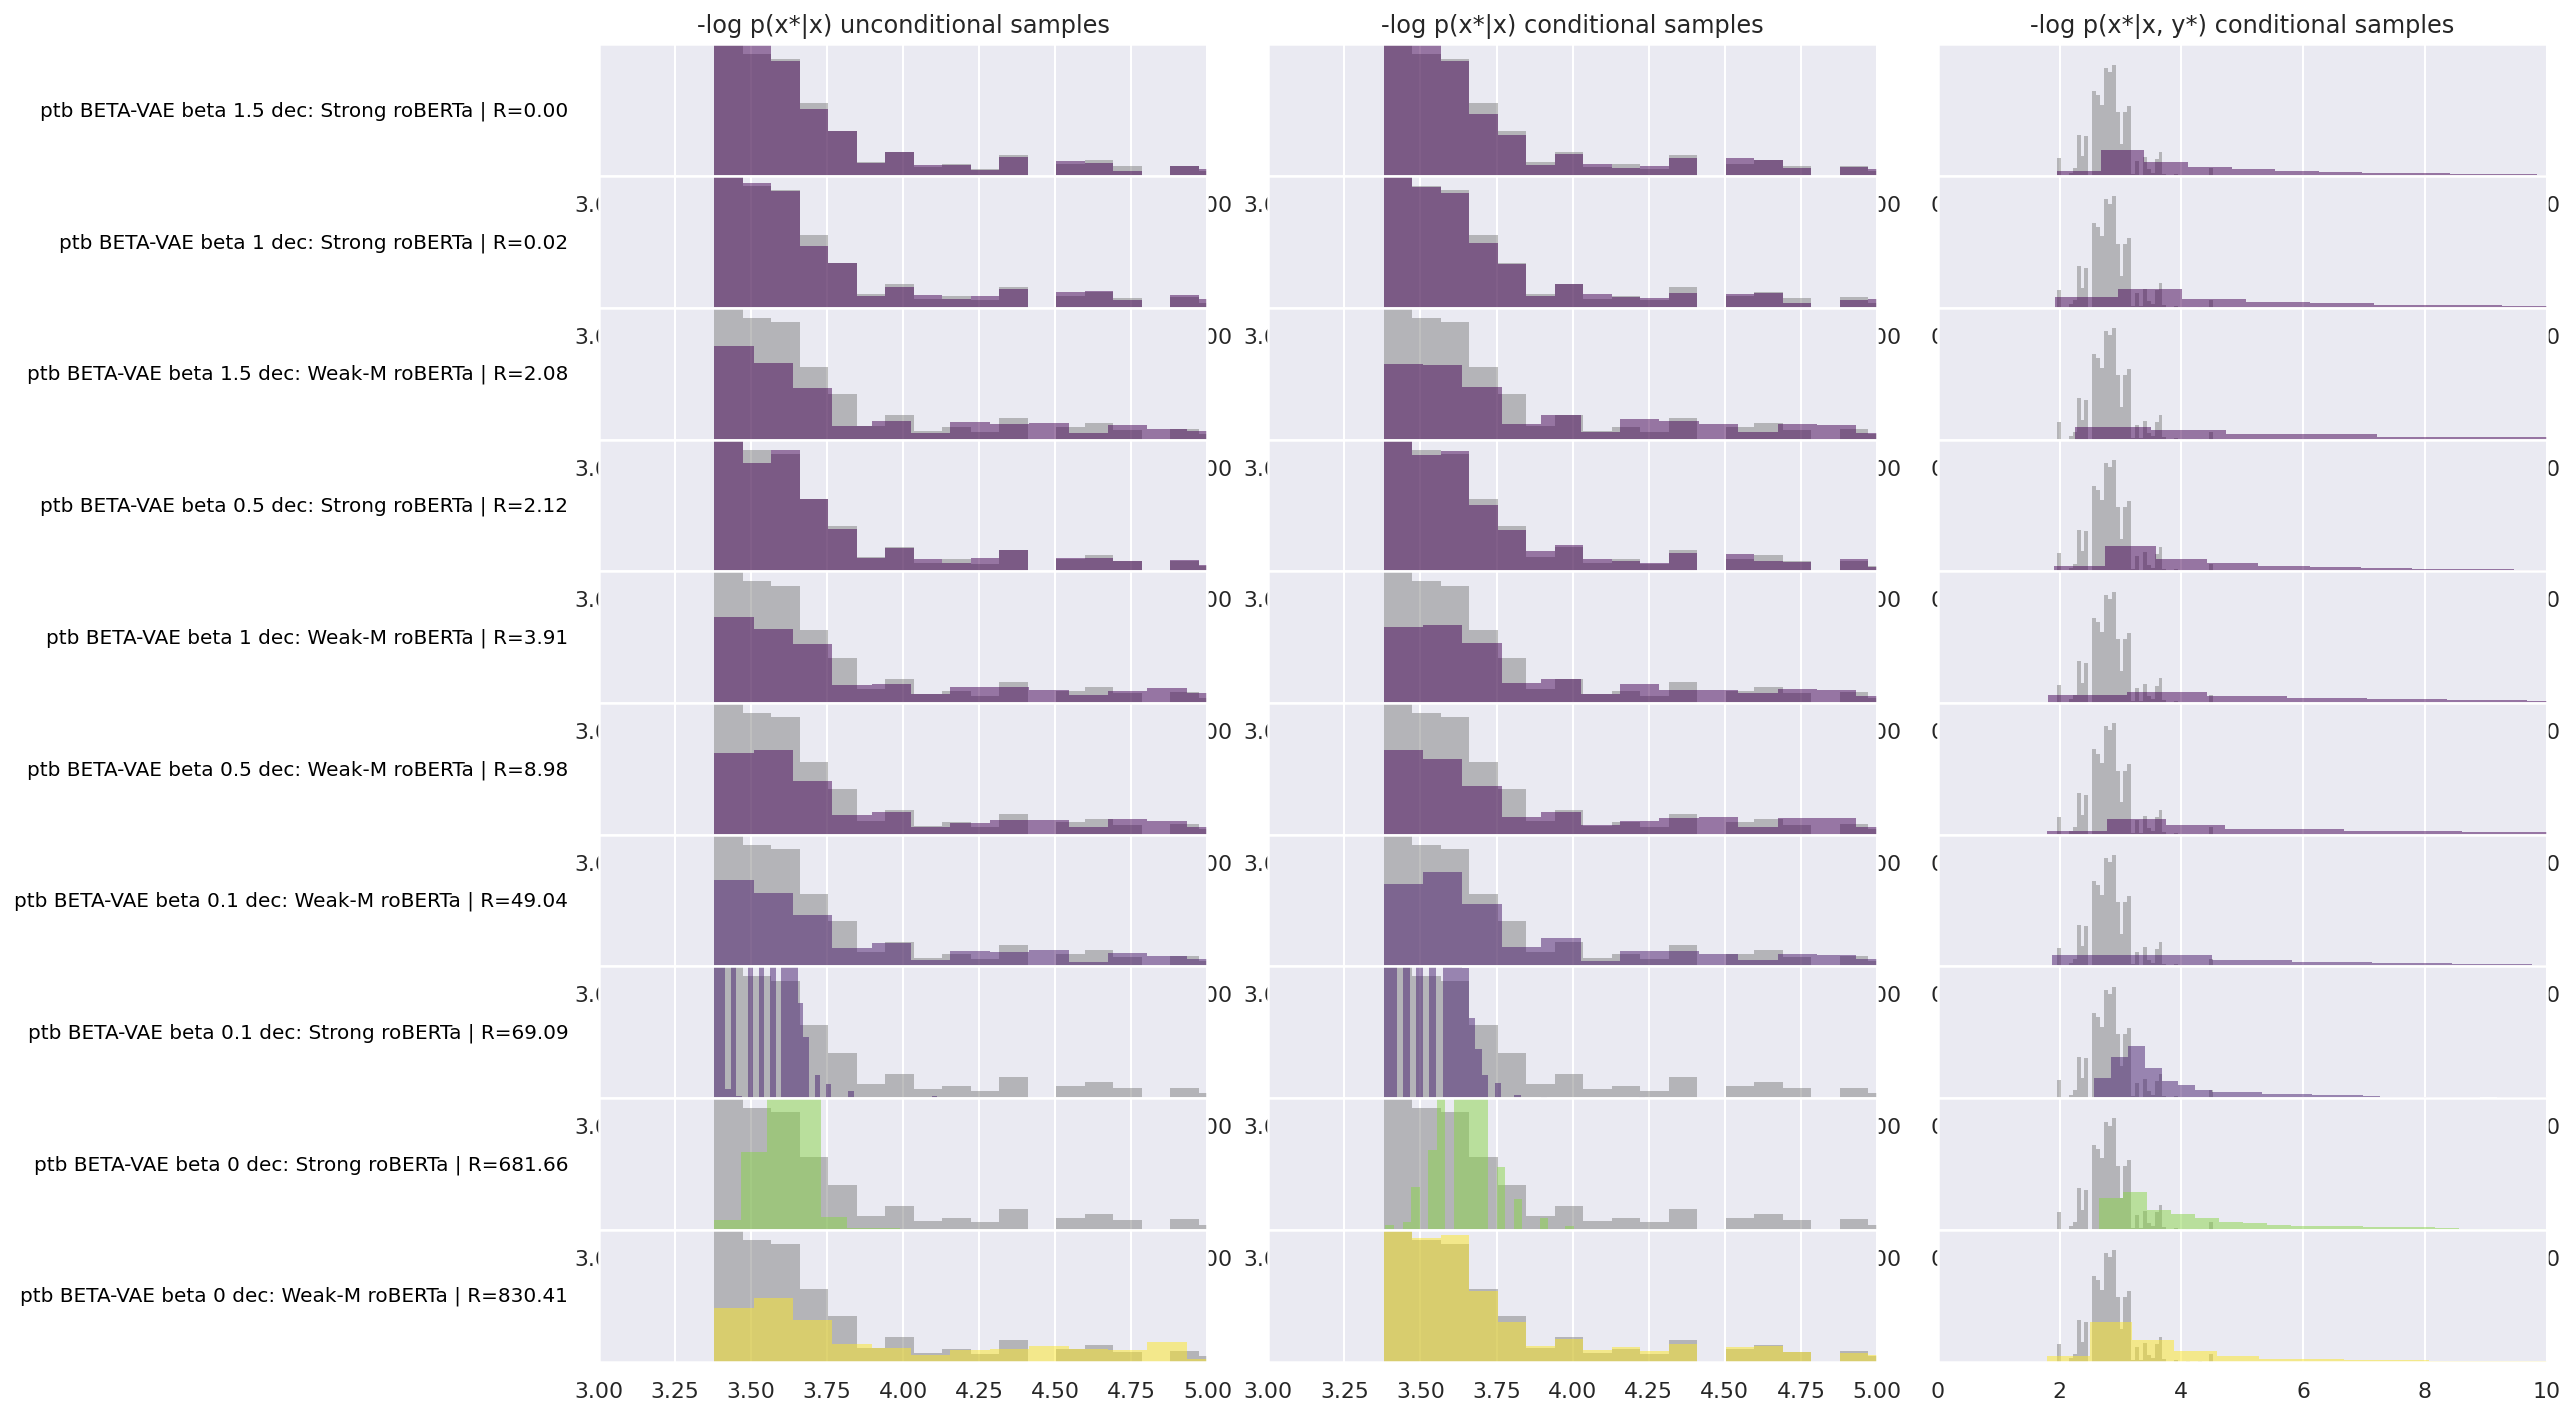

In [68]:
# ----------------------------------------------------------------------------------------------------
# sort_on, sort_name, sort_ascend = 'valid-MMD', 'MMD', True                  # valid MMD
# sort_on, sort_name, sort_ascend = 'valid-elbo mean', 'ELBO', True                # valid ELBO
sort_on, sort_name, sort_ascend = 'valid-kl_prior_post mean', 'R', True          # valid R
# sort_on, sort_name, sort_ascend = 'valid-distortion mean', 'D', True             # valid D mean

# sort_on, sort_name, sort_ascend = 'surpr_sample', 'surpr. samples', True         # LL samples
# sort_on, sort_name, sort_ascend = 'surpr_data_valid', 'surpr. data', True        # LL valid data samples
# sort_on, sort_name, sort_ascend = 'surpr_recons_valid', 'surpr. recons', True    # LL valid reconstructions

# ----------------------------------------------------------------------------------------------------
model_cols = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
model_col_names = ["-log p(x*|x) unconditional samples", "-log p(x*|x) conditional samples", "-log p(x*|x, y*) conditional samples"]

ncols = len(model_cols)
nrows = len(surprisal_values.keys()) - 1

print("Rows, cols:", ncols, nrows)
# nrows = 4

hist_kwargs = dict(lw=0, alpha=0.5, density=True, bins=40)

df_sort_on = global_stats_df.sort_values(sort_on, ascending=sort_ascend)[sort_on]
sort_on_labels, sort_on_values = df_sort_on.index, df_sort_on.values
labels = [f"{l} | {sort_name}={v:.2f}" for l, v in zip(sort_on_labels, sort_on_values)]

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*6, nrows*1.0)) # , sharex="row", sharey="row"

minima, maxima = min(sort_on_values), max(sort_on_values)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for col, col_name in enumerate(model_cols):
    row = 0
    for idx, group_name in enumerate(sort_on_labels):
        
        color = mapper.to_rgba(sort_on_values[row])
        
        axs[row, col].hist(surprisal_values["data_group"][model_cols[col]], color="grey", **hist_kwargs)
        axs[row, col].hist(surprisal_values[group_name][model_cols[col]], color=color, **hist_kwargs)
        
        if col == 0:
            axs[row, col].text(-0.05, .5, labels[row], color='black', fontsize=10, ha="right", va="center", 
                               transform=axs[row, col].transAxes)
        
        
        axs[row, col].set_yticks([])
        axs[row, col].set_ylim([0, 2.0])
        if "unconditional" in model_cols[col]:
            axs[row, col].set_xlim([3, 5])
        else:
            axs[row, col].set_xlim([0, 10])
        
        if row == 0:
            axs[row, col].set_title(model_col_names[col])
        
#         if row == 3: break
            
        row += 1
        

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# Analyse surprisal distribution with a DP mixture of truncated normals

In [70]:
dp_mixtures = dict()

MAX_SAMPLES_PER_GROUP = 200

NUM_COMPS = 3
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1000

for stat_name in model_cols:
    print(stat_name)

    group_names = []
    observations = []

    for k, v in surprisal_values.items():
        group_names.append(k)
        observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

    dp_mixture = DPMixture(
        group_names, 
        observations, 
        obs_dist="truncated_normal", 
        DP_alpha=1., 
        num_comps=NUM_COMPS, 
        num_samples=NUM_SAMPLES, 
        num_chains=NUM_CHAINS, 
        num_warmup=NUM_WARMUP
    )

    dp_mixture.run()

    dp_mixtures[stat_name] = dp_mixture

unconditional_unconditional


sample: 100%|██████████| 1100/1100 [00:26<00:00, 42.13it/s, 127 steps of size 1.42e-02. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.53      0.06      0.53      0.43      0.62   1021.67      1.00
 beta[0,1]      0.32      0.09      0.33      0.18      0.46    916.94      1.00
 beta[1,0]      0.21      0.04      0.21      0.14      0.28    873.57      1.00
 beta[1,1]      0.26      0.05      0.26      0.18      0.35   1329.59      1.00
 beta[2,0]      0.44      0.06      0.44      0.34      0.53    965.60      1.00
 beta[2,1]      0.40      0.07      0.40      0.28      0.51   1355.95      1.00
 beta[3,0]      0.24      0.04      0.24      0.17      0.31   1473.22      1.00
 beta[3,1]      0.17      0.05      0.17      0.09      0.25   1409.62      1.00
 beta[4,0]      0.25      0.04      0.25      0.17      0.32    846.47      1.00
 beta[4,1]      0.26      0.05      0.26      0.18      0.34    551.94      1.00
 beta[5,0]      0.43      0.06      0.43      0.34      0.52   1060.28      1.00
 beta[5,1]      0.46      0

sample: 100%|██████████| 1100/1100 [00:20<00:00, 54.92it/s, 63 steps of size 1.18e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.49      0.05      0.49      0.41      0.57    978.02      1.00
 beta[0,1]      0.51      0.07      0.51      0.41      0.62   1010.40      1.00
 beta[1,0]      0.24      0.04      0.24      0.17      0.31   1155.37      1.00
 beta[1,1]      0.16      0.05      0.16      0.07      0.24   1292.13      1.00
 beta[2,0]      0.47      0.05      0.47      0.38      0.55   1269.62      1.00
 beta[2,1]      0.44      0.07      0.44      0.33      0.56   1497.03      1.00
 beta[3,0]      0.19      0.04      0.19      0.12      0.26   1489.66      1.00
 beta[3,1]      0.26      0.05      0.26      0.18      0.33   1203.52      1.00
 beta[4,0]      0.25      0.04      0.25      0.19      0.33    650.50      1.00
 beta[4,1]      0.13      0.05      0.13      0.06      0.22    623.43      1.00
 beta[5,0]      0.54      0.05      0.54      0.46      0.63   1403.51      1.00
 beta[5,1]      0.47      0

sample: 100%|██████████| 1100/1100 [00:18<00:00, 60.89it/s, 15 steps of size 1.75e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.44      0.07      0.44      0.32      0.56    731.95      1.00
 beta[0,1]      0.65      0.08      0.65      0.52      0.77    719.14      1.00
 beta[1,0]      0.22      0.09      0.22      0.08      0.36    351.38      1.00
 beta[1,1]      0.27      0.05      0.27      0.20      0.36    626.20      1.00
 beta[2,0]      0.50      0.08      0.50      0.37      0.62    660.68      1.00
 beta[2,1]      0.69      0.08      0.70      0.56      0.83    487.14      1.00
 beta[3,0]      0.20      0.08      0.20      0.07      0.32    724.89      1.00
 beta[3,1]      0.35      0.05      0.36      0.27      0.43   1050.18      1.00
 beta[4,0]      0.23      0.09      0.23      0.08      0.37    573.69      1.00
 beta[4,1]      0.27      0.05      0.27      0.19      0.34    531.51      1.00
 beta[5,0]      0.48      0.07      0.48      0.38      0.61    670.61      1.00
 beta[5,1]      0.76      0

# Plot the DP Mixture fits on surprisal values

UNCONDITIONAL_UNCONDITIONAL


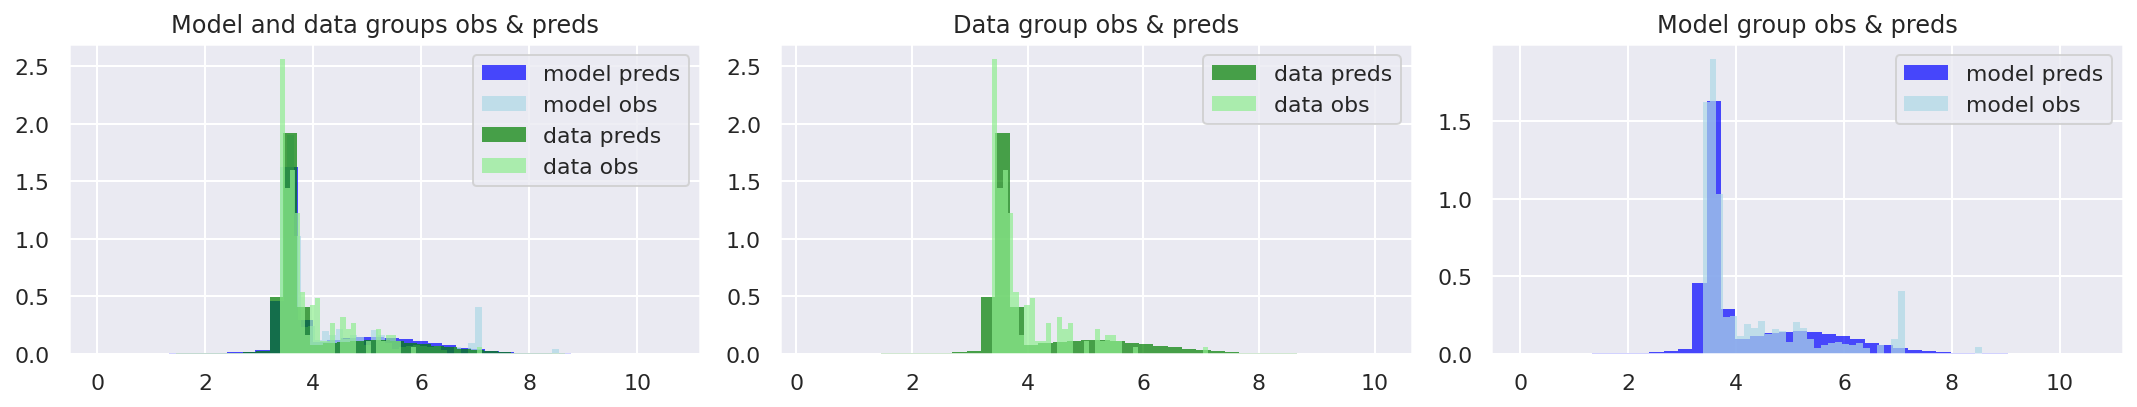

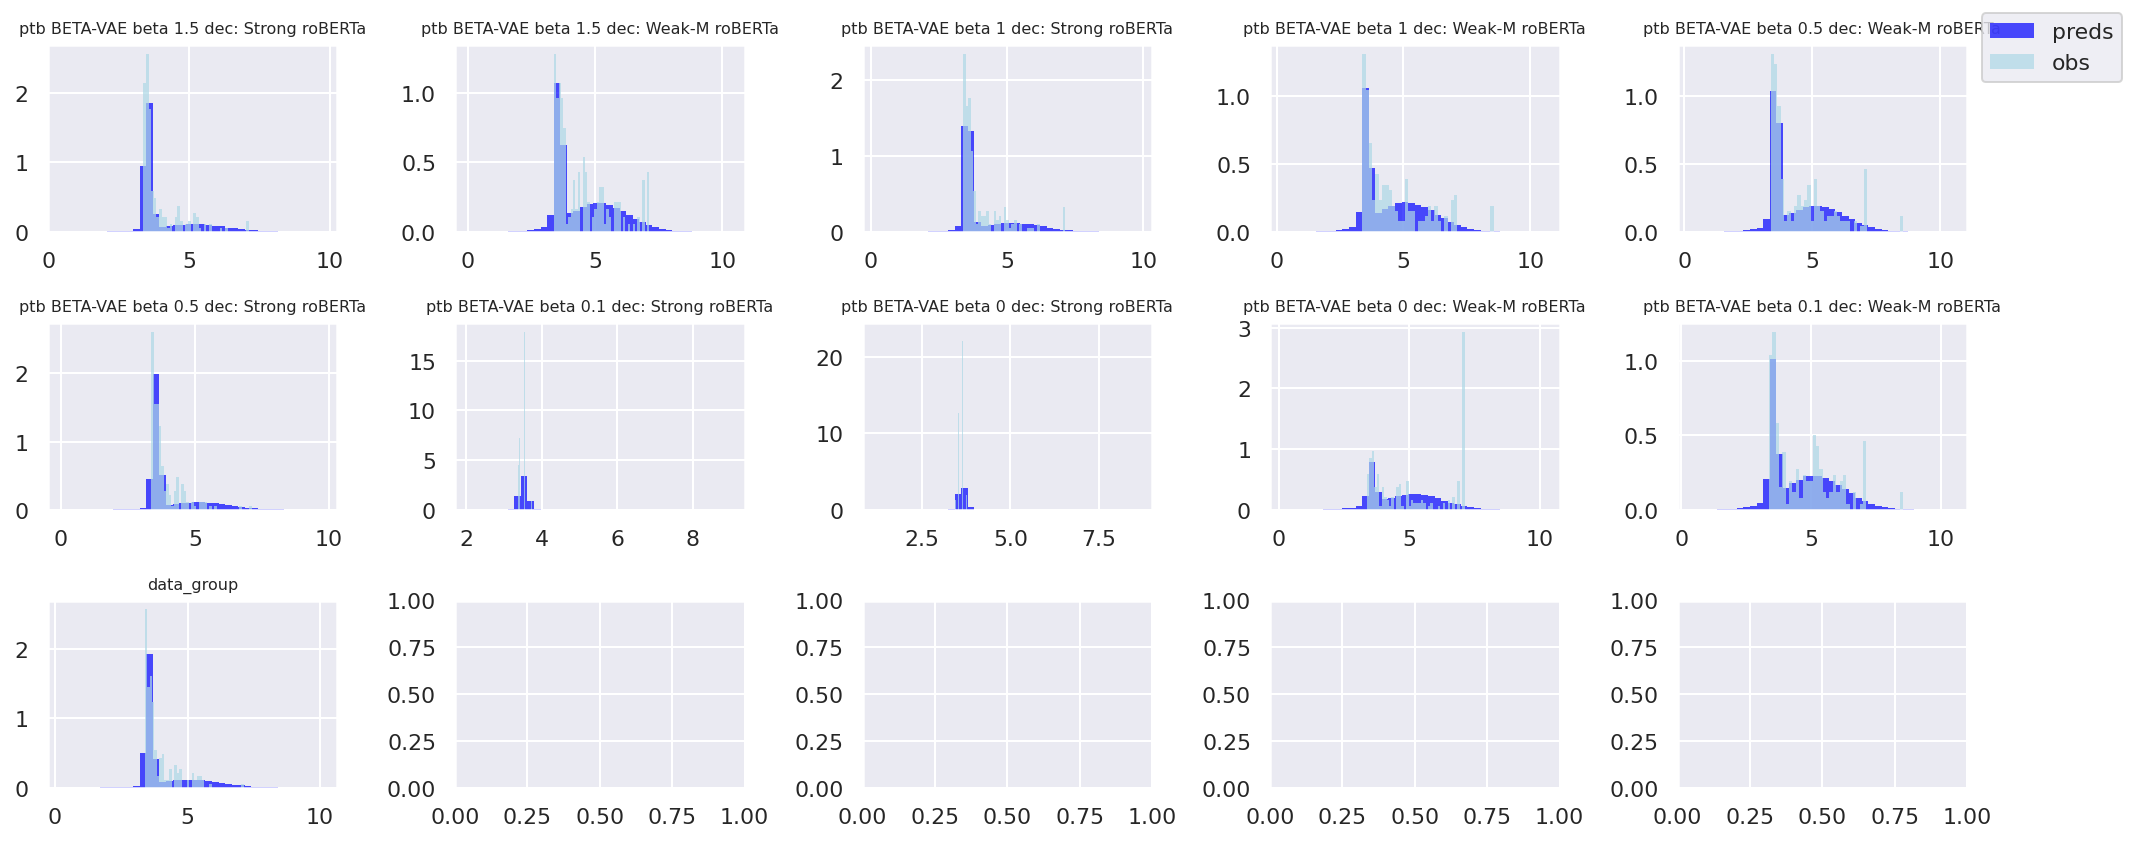

UNCONDITIONAL_CONDITIONAL


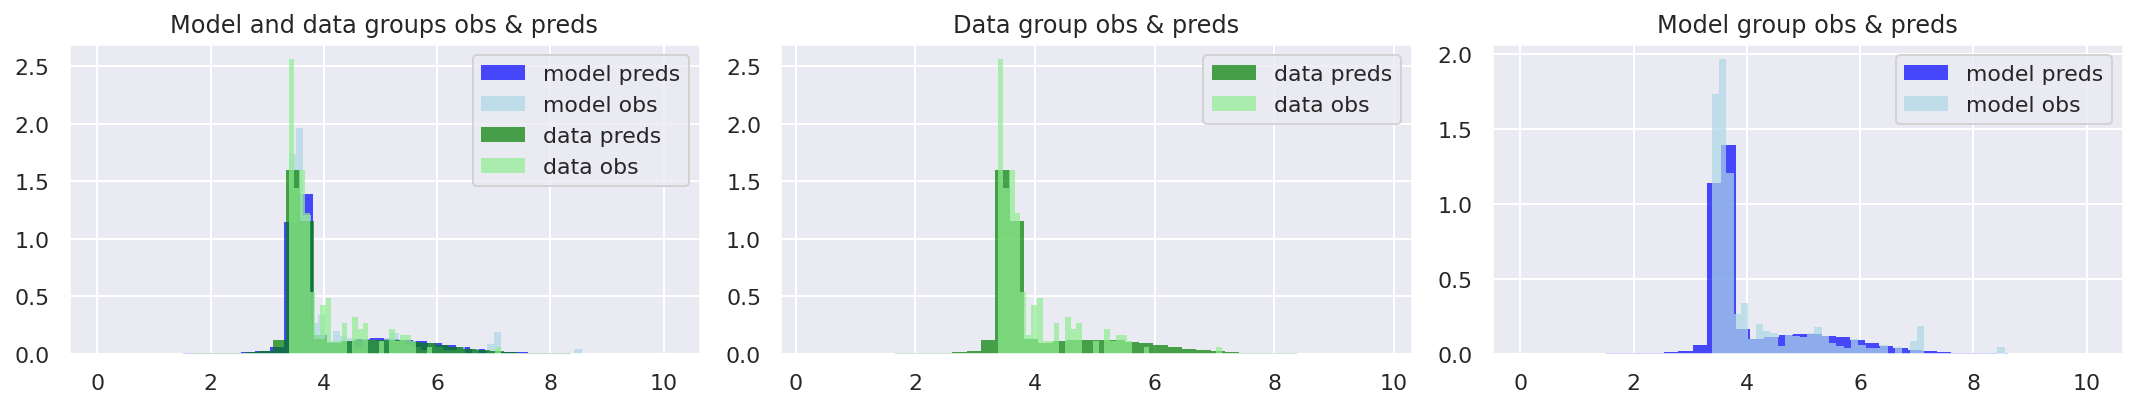

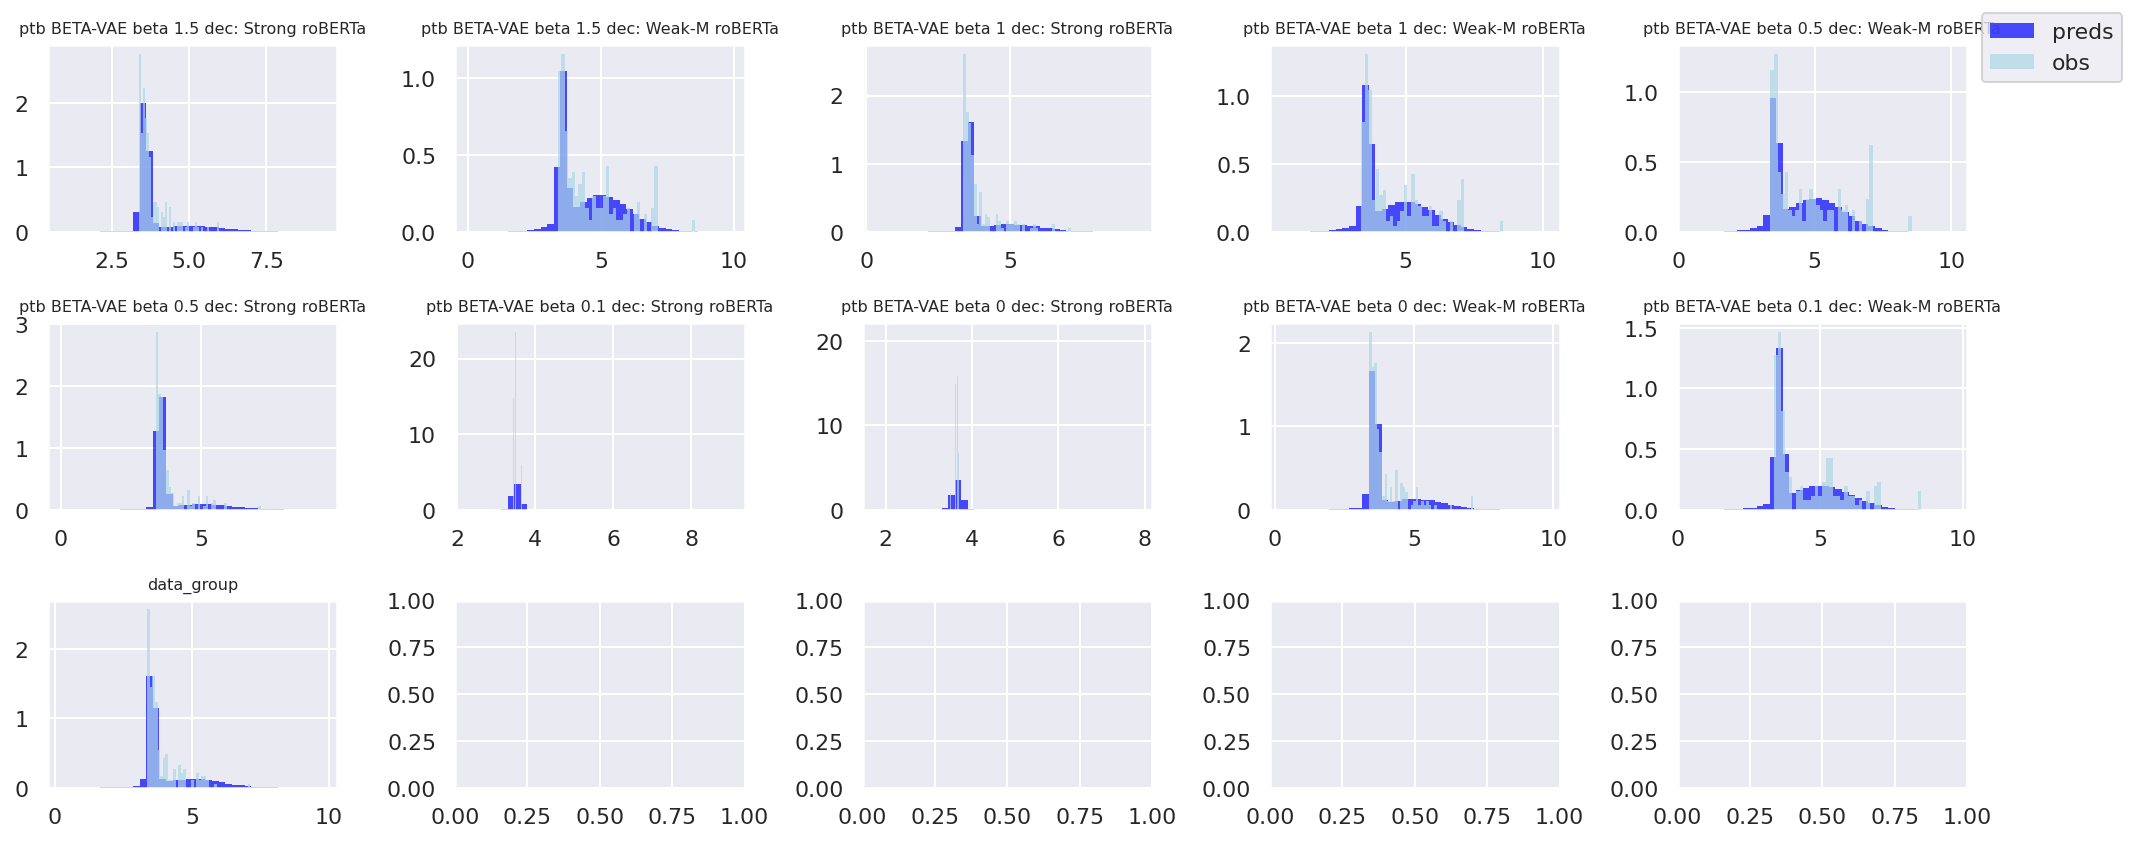

CONDITIONAL_CONDITIONAL


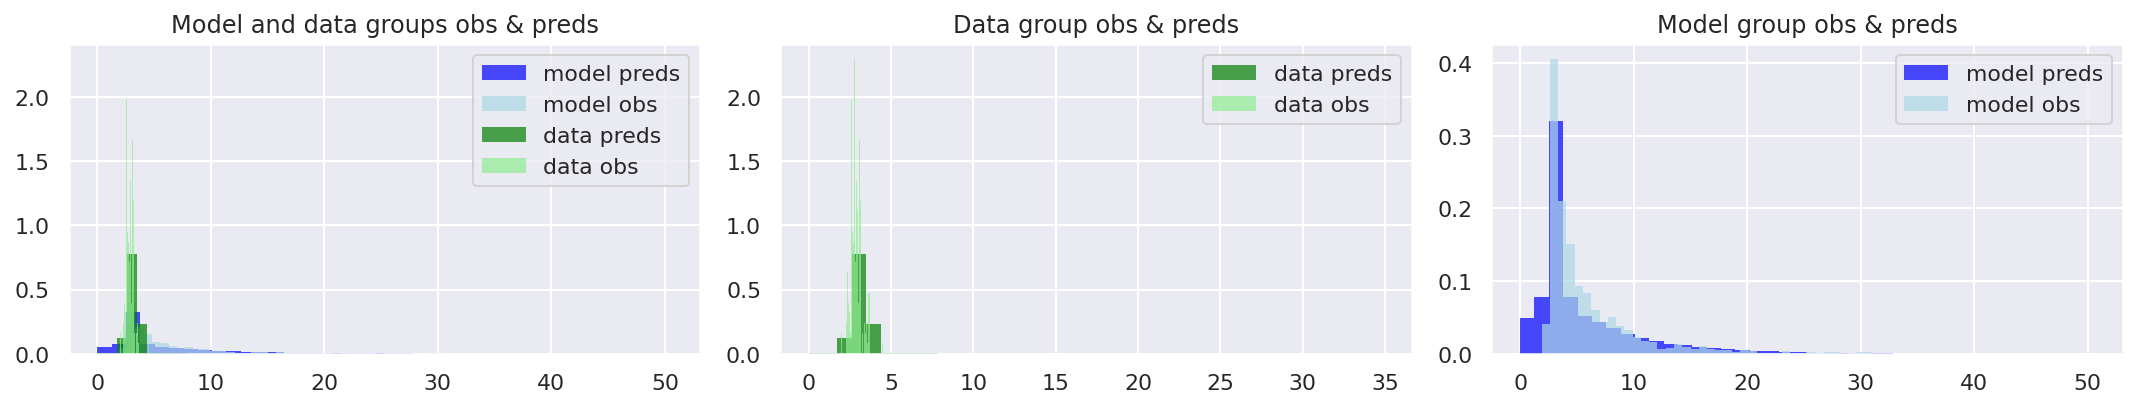

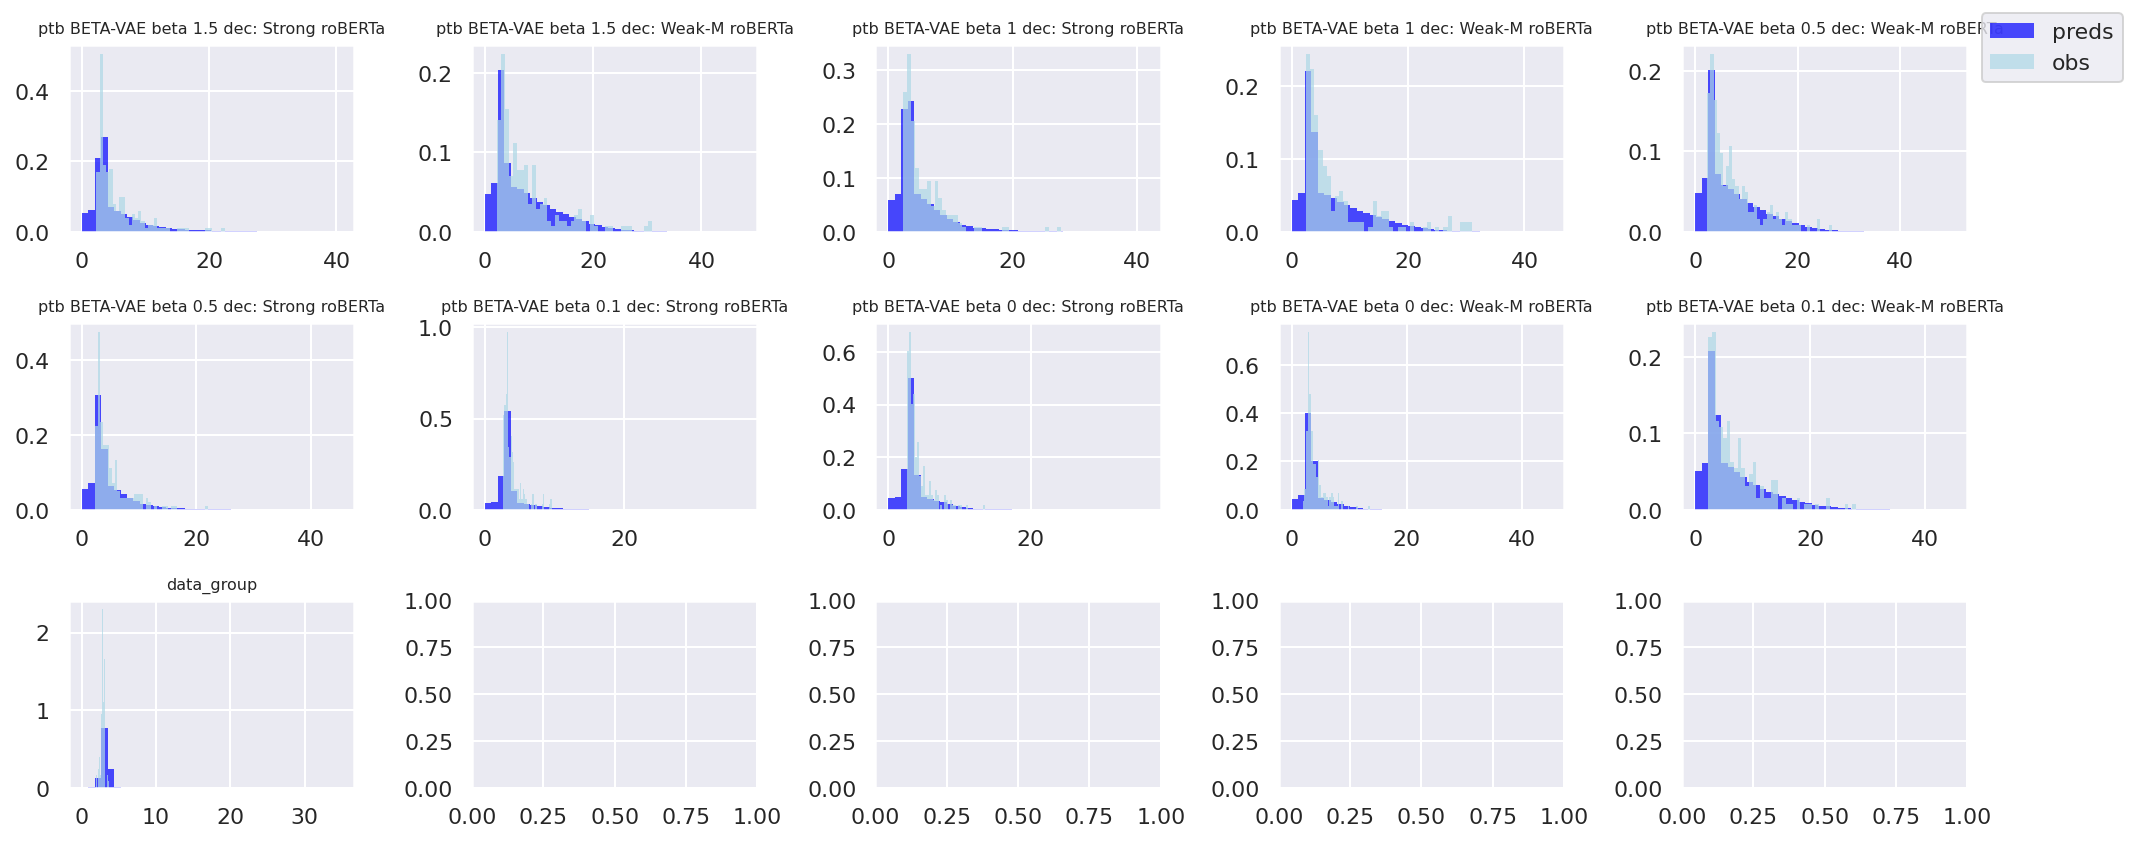

In [71]:
for stat, dp_mixture in dp_mixtures.items():
    print(stat.upper())

    plot_model_data_preds_obs(dp_mixture)
    plot_all_groups_preds_obs(dp_mixture)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [72]:
all_df = compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values)

UNCONDITIONAL_UNCONDITIONAL
UNCONDITIONAL_CONDITIONAL
CONDITIONAL_CONDITIONAL


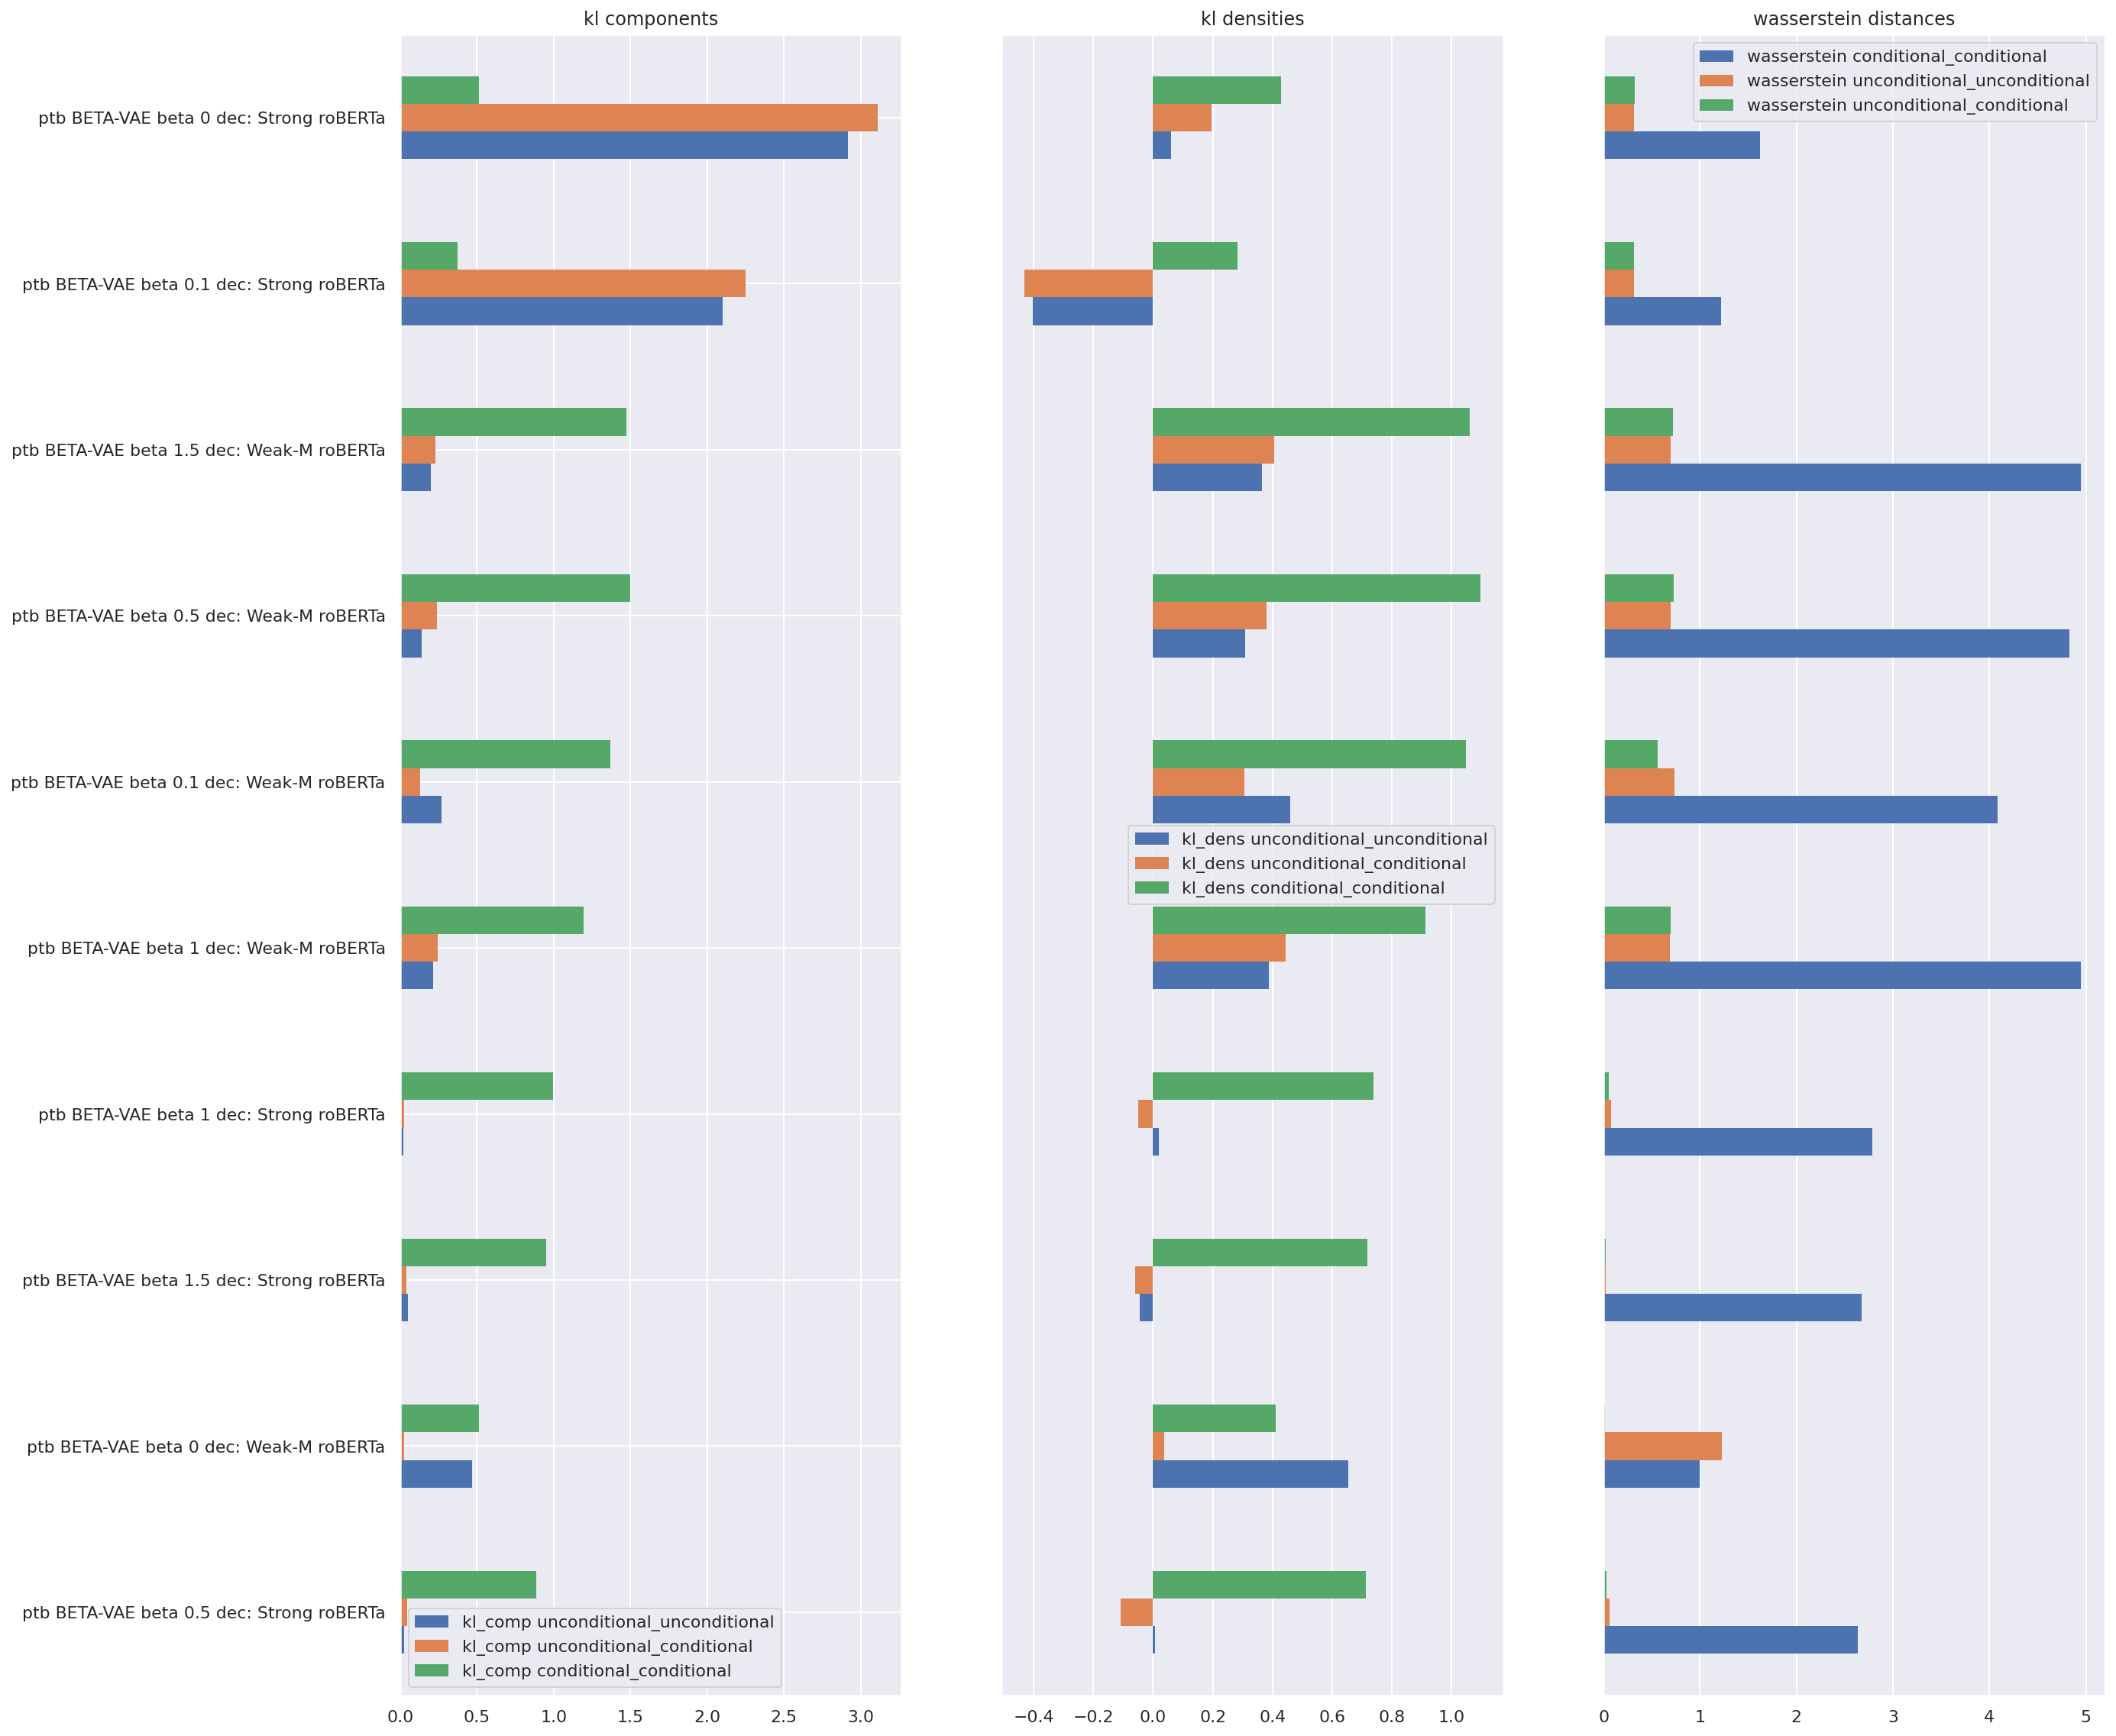

In [73]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only=None)

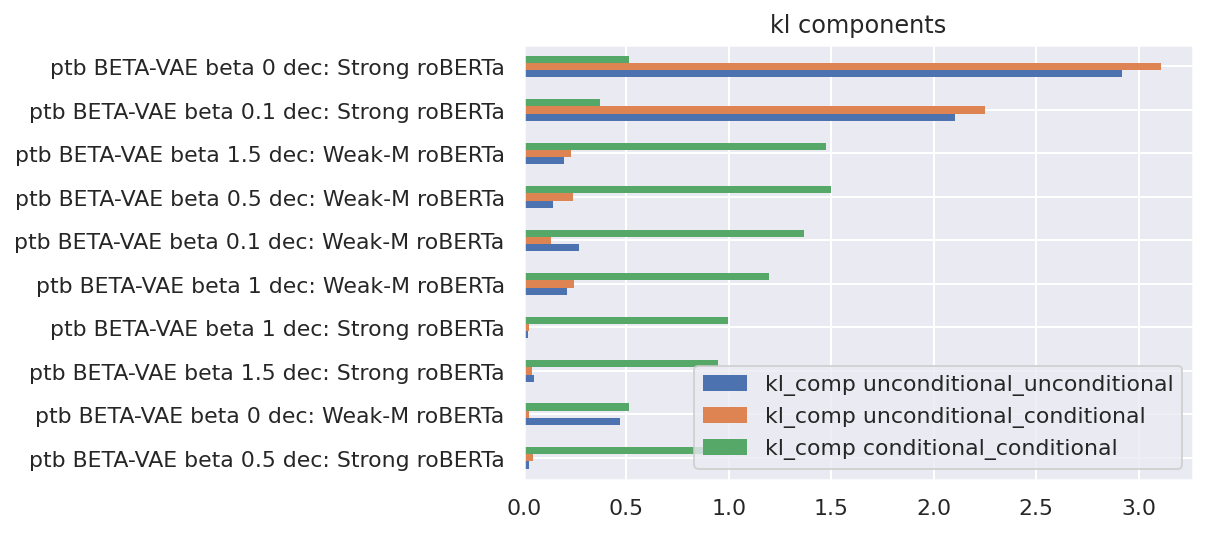

In [74]:
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp")

# Old code

In [ ]:
# import functools

# def model_beta_binomial(self, y=None):
#     print("model_beta_binomial")
#     """
#     Pyro joint distribution.

#     Parameter:

#     y: observations as returned by self.prepare or None. 
#         If None, the 'obs' node of the graphical model will be resampled.
#     """

#     N, G = self.N, self.G
#     T = self.T
    
#     total_count = 63
    
#     with numpyro.plate("components", T):  
# #         # construct the components
# #         # [T]
# #         lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))   
# #         rate = numpyro.deterministic("rate", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler 
        
#         # https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html (Model 3 section)
#         # The beta distribution is the conjugate prior for the binomial, meaning that the posterior is 
#         # known to be a beta distribution. This also allows us to interpret the prior’s parameters as 
#         # prior data, with α−1 being the prior number of successes and β−1 being the prior number of failures, 
#         # and α=β=1 corresponding to no prior observations and thus a uniform distribution.
#         a = np.mean(self.y) + 1 # alpha = # successes + 1
#         b = np.mean(total_count - (self.y)) + 1 # beta = # failures + 1
        
#         lamb = numpyro.sample("lambda", dist.Beta(a, b))
#         beta = numpyro.deterministic("beta", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler

#     # Sample mixing weights    
#     with numpyro.plate("DPs", G):
#         # [G, T-1]
#         mix_beta = numpyro.sample(
#             "mix_beta", 
#             dist.Beta(
#                 np.ones(1), 
#                 np.ones(1) * self.DP_alpha
#             ).expand((T-1,)).to_event(1)
#         )

#     # [G, T]
#     omega = numpyro.deterministic("omega", self.mix_weights(mix_beta))

#     with numpyro.plate("observations", N):   
#         # [N, T]
#         omega_x = numpyro.deterministic("omega_x", omega[self.x])

#         # [N]
#         # BUG: during .run() an omega of shape [2000, 5] leads to a z of [5, 1]? [2000,]
#         z = numpyro.sample("z", dist.Categorical(probs=omega_x))

#         # [N]
#         beta_z = numpyro.deterministic("beta_z", beta[z])

#         # [N]
#         # Construct the likelihood function            
#         return numpyro.sample("y", dist.Binomial(logits=beta_z, total_count=total_count), obs=y)
    